
<center>

<font font size =8>**Introduction**



# 🌟 **Lung Disease Detection from X-Ray Images Using Deep Learning** 🌟

---

## 🔍 **Summary**  
This project aims to develop a machine learning pipeline for classifying lung diseases using X-ray images. The dataset comprises nine distinct classes representing various lung conditions, including pneumonia, emphysema, and normal anatomy. We begin with exploratory data analysis (EDA) to understand the dataset's structure and characteristics, followed by image preprocessing to ensure the data is suitable for model training. Our approach leverages convolutional neural networks (CNNs) and transfer learning techniques to build and train classification models. The model performance is evaluated using metrics such as accuracy, confusion matrices, and ROC curves. This project aims to enhance diagnostic efficiency by providing an automated system for lung disease detection.

---

## 📖 **Introduction**  
Lung diseases, including pneumonia, tuberculosis, and emphysema, are significant contributors to global health issues, causing substantial morbidity and mortality. Early diagnosis is essential for effective treatment; however, the manual interpretation of chest X-rays is often time-consuming and subject to variability among radiologists. The rise of deep learning has introduced powerful tools for automating medical imaging tasks, offering a promising solution for consistent and efficient disease detection.  

In this project, we focus on developing a deep learning-based image classification system capable of identifying lung diseases from X-ray images. By utilizing a publicly available dataset with nine disease categories, we aim to implement and compare different models, including CNNs and transfer learning with pretrained models. Our goal is to evaluate the performance of these models and demonstrate their potential in assisting healthcare professionals with accurate and timely diagnostics.

---

## 📊 **Dataset Description**  
The dataset used in this project is the **Lung X-Ray dataset**, sourced from **[Kaggle](https://www.kaggle.com/datasets/fernando2rad/x-ray-lung-diseases-images-9-classes)**. It consists of X-ray images organized into **nine classes** representing various lung conditions, including:

1. **Normal anatomy**  
2. **Inflammatory processes** (e.g., pneumonia)  
3. **Increased density** (e.g., pleural effusion)  
4. **Decreased density** (e.g., pneumothorax)  
5. **Obstructive diseases** (e.g., emphysema)  
6. **Infectious degenerative diseases** (e.g., tuberculosis)  
7. **Encapsulated lesions** (e.g., nodules, cysts)  
8. **Mediastinal changes** (e.g., pericarditis)  
9. **Thoracic structural changes** (e.g., atelectasis)  

📌 The dataset is split into **training**, **validation**, and **testing subsets** for effective model evaluation.

#<font size=6>**Importing Necessary Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip uninstall -y tensorflow
!pip install tensorflow-cpu==2.12.0

In [ ]:
!pip install transformers

In [ ]:
!pip install tensorflow-hub

  Using cached tensorflow-2.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached tensorflow-2.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
Using cached tensorboard-2.15.2-py3-none-any.whl (5.5 MB)
Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl (441 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorbo

In [ ]:
# General Libraries
import os
import shutil
import random
import hashlib

# Data Manipulation and Analysis
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

# Image Processing Libraries
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from torchvision.transforms.functional import to_pil_image

# Deep Learning Frameworks
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# PyTorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Miscellaneous Libraries
import visualkeras
from timm import create_model

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.1


#<font size=6>**Loading The Data**

**Renaming Folders in Dataset**

---

In this code, we define a `rename_map` dictionary to map the original folder names to simplified names. We then iterate through each folder, check if the folder exists in the dataset, and if it does, we rename it by moving it to the new path with the simplified name.


In [ ]:
dataset_path = '/content/drive/MyDrive/ML Lung Dataset'

# Mapping for simplified names
rename_map = {
    '00 Anatomia Normal': 'Normal',
    '01 Processos Inflamatórios Pulmonares (Pneumonia)': 'Inflammatory_Pneumonia',
    '02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema)': 'High_Density',
    '03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio)': 'Low_Density',
    '04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia)': 'Obstructive_Diseases',
    '05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose)': 'Infectious_Diseases',
    '06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases)': 'Encapsulated_Lesions',
    '07 Alterações de Mediastino (Pericardite, Malformações Arteriovenosas, Linfonodomegalias)': 'Mediastinal_Changes',
    '08 Alterações do Tórax (Atelectasias, Malformações, Agenesia, Hipoplasias)': 'Thoracic_Changes',
}

# Rename folders
for old_name, new_name in rename_map.items():
    old_path = os.path.join(dataset_path, old_name)
    new_path = os.path.join(dataset_path, new_name)
    if os.path.exists(old_path):
        shutil.move(old_path, new_path)

**Counting Images in Each Class Folder**

---

This code counts the number of images in each class folder. It first lists all the folders (representing the classes) in the dataset directory. Then, for each class, it counts the number of images (files) in that folder by using `os.listdir()` to list the folder contents. Finally, it displays the class name alongside the number of images in that class.

In [ ]:
# Count images in each class folder
classes = os.listdir(dataset_path)
class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in classes}

# Display the counts
for cls, count in class_counts.items():
    print(f"Class '{cls}': {count} images")

Class 'Normal': 1340 images
Class 'Inflammatory_Pneumonia': 1060 images
Class 'High_Density': 678 images
Class 'Low_Density': 629 images
Class 'Obstructive_Diseases': 644 images
Class 'Infectious_Diseases': 594 images
Class 'Encapsulated_Lesions': 658 images
Class 'Mediastinal_Changes': 596 images
Class 'Thoracic_Changes': 544 images


#<font size=6>**Exploratory Data Analysis (EDA)**

**Visualizing Class Distribution**

---

In this code, we sort the classes by the number of images in descending order. Then, we plot the class distribution using a bar chart with a 'dodgerblue' color palette. The class names are displayed on the x-axis with rotated labels for readability, and the number of images is shown on the y-axis. This method is used to easily compare the number of images across classes in a clear and visually appealing way.

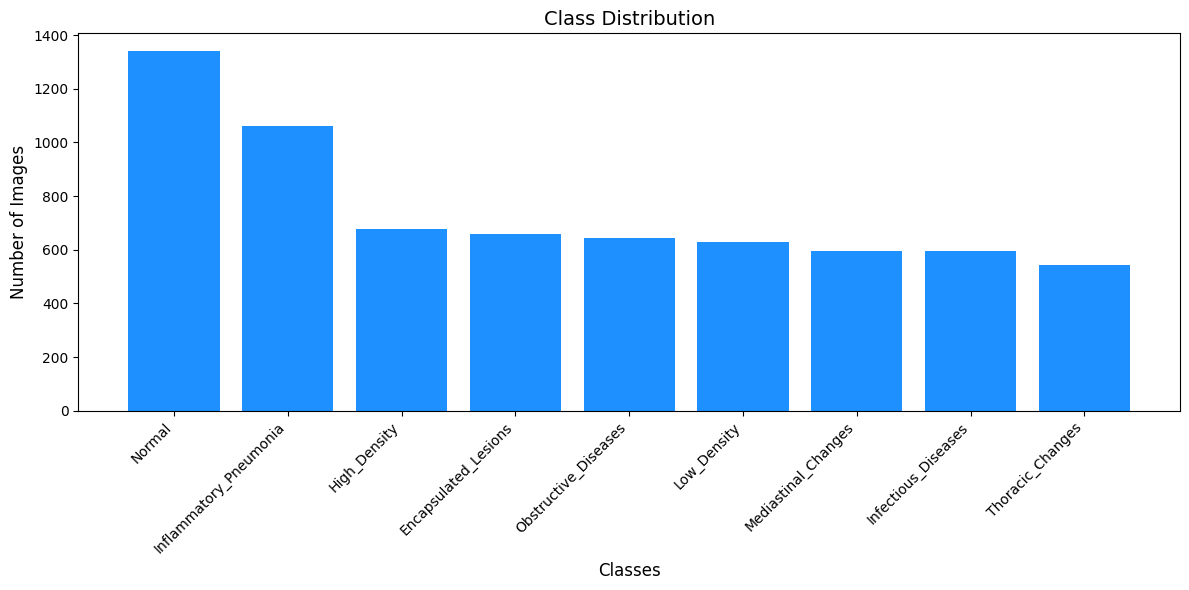

In [ ]:
# Sort the classes by count in descending order
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

# Unpack sorted data
sorted_class_names, sorted_class_counts = zip(*sorted_classes)

# Plot class distribution with a new color palette
plt.figure(figsize=(12, 6))
plt.bar(sorted_class_names, sorted_class_counts, color='dodgerblue')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Class Distribution', fontsize=14)
plt.tight_layout()
plt.show()

The dataset exhibits class imbalance, with "Normal" having a significantly higher number of samples than other classes. This may impact model performance.

**Visualizing Class Distribution as Pie Chart**

---

In this code, we calculate the percentage of each class and sort them by percentage in descending order. We then use shades of blue for the pie chart to create a visually appealing representation. The pie chart shows the class distribution with labels and percentages. We used this method to clearly display the proportional distribution of images across different classes.


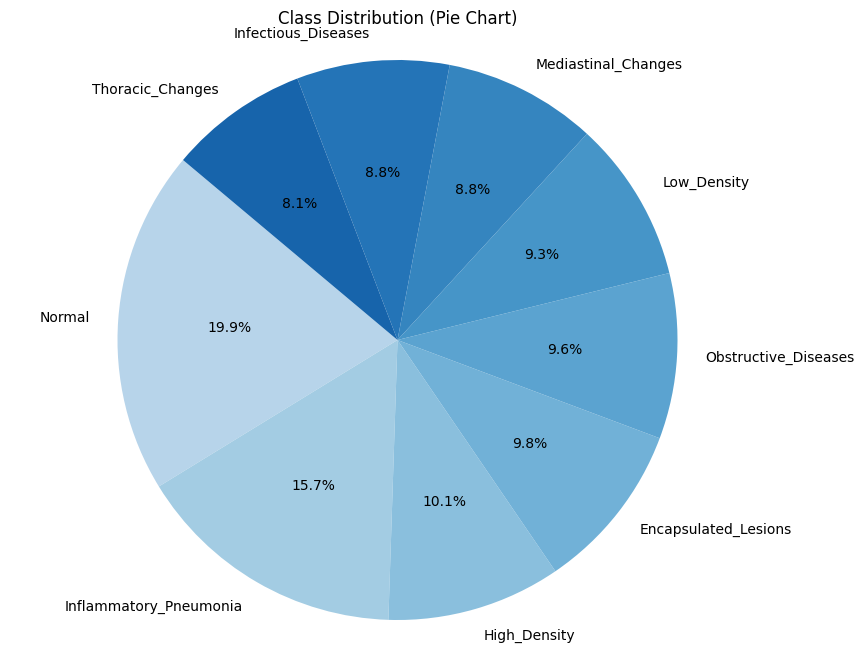

In [ ]:
# Calculate the percentage of each class (if not already done)
total_images = sum(class_counts.values())
class_percentages = {k: (v / total_images) * 100 for k, v in class_counts.items()}

# Sort classes by percentage
sorted_percentage = sorted(class_percentages.items(), key=lambda x: x[1], reverse=True)
sorted_class_names, sorted_class_percentages = zip(*sorted_percentage)

# Generate shades of blue using a color map
blue_shades = plt.cm.Blues(np.linspace(0.3, 0.8, len(sorted_class_names)))

# Plotting the pie chart
plt.figure(figsize=(10, 8))
plt.pie(sorted_class_percentages, labels=sorted_class_names, autopct='%1.1f%%', startangle=140, colors=blue_shades)
plt.title('Class Distribution (Pie Chart)')
plt.axis('equal')
plt.show()


The "Normal" class constitutes nearly 20% of the dataset, significantly outweighing the other classes which each represent less than 10%. This class imbalance may pose challenges during model training and evaluation.

**Displaying Random Images from Each Class**

---

In this code, we select a random image from each class and display it in a 3x3 grid. We use the `random.choice()` function to pick an image from each class folder and plot it with the corresponding class name as the title. This allows us to visually inspect a random image from each class in the dataset.

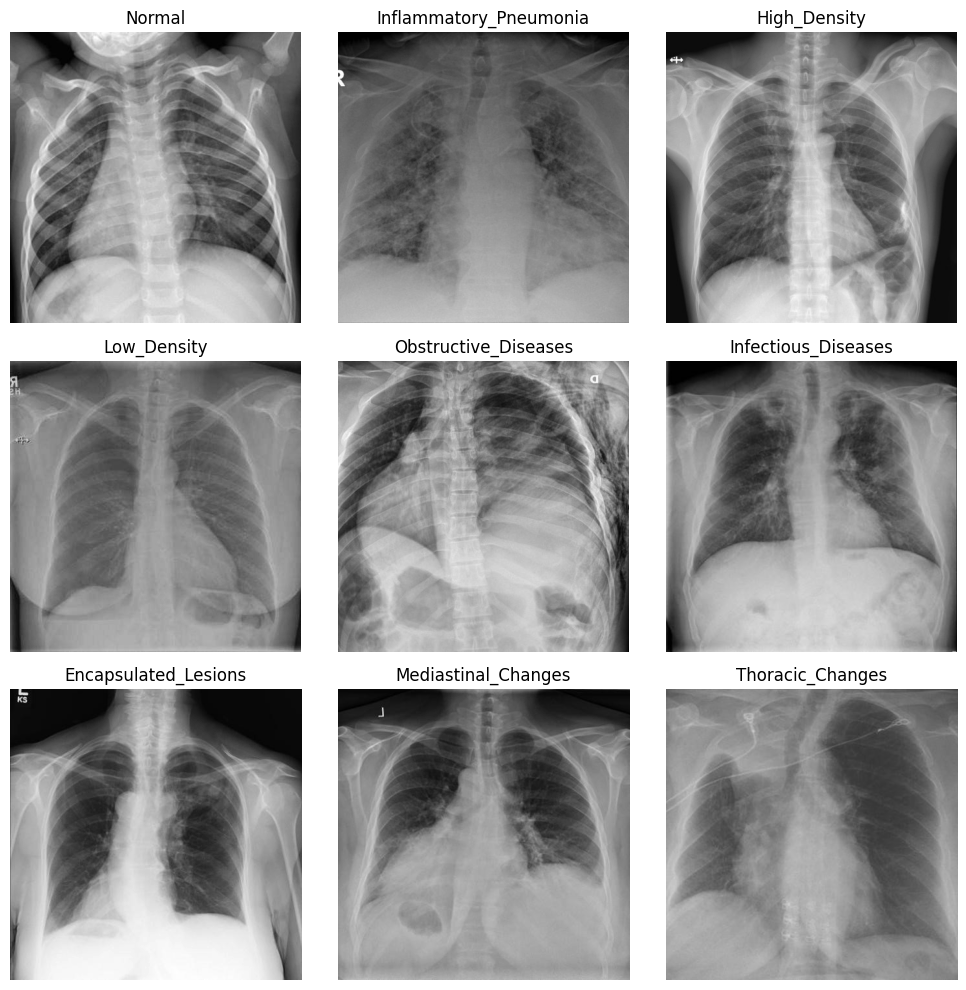

In [ ]:
# Select a random image from each class
plt.figure(figsize=(10, 10))

for i, class_name in enumerate(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        # Pick a random image from the class folder
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        random_image = random.choice(image_files)
        img_path = os.path.join(class_path, random_image)
        img = Image.open(img_path)

        # Plot the image as grayscale
        plt.subplot(3, 3, i + 1)  # 3x3 grid for 9 classes
        plt.imshow(img, cmap='gray')
        plt.title(class_name)
        plt.axis('off')

plt.tight_layout()
plt.show()

**Visualizing Image Size Distribution**

---

In this code, we iterate through each class folder, load each image, and fetch its dimensions (width and height). We store the sizes in a list and then separate the width and height into two lists. We use histograms to visualize the distribution of image widths and heights. This approach helps us understand the variation in image sizes within the dataset.


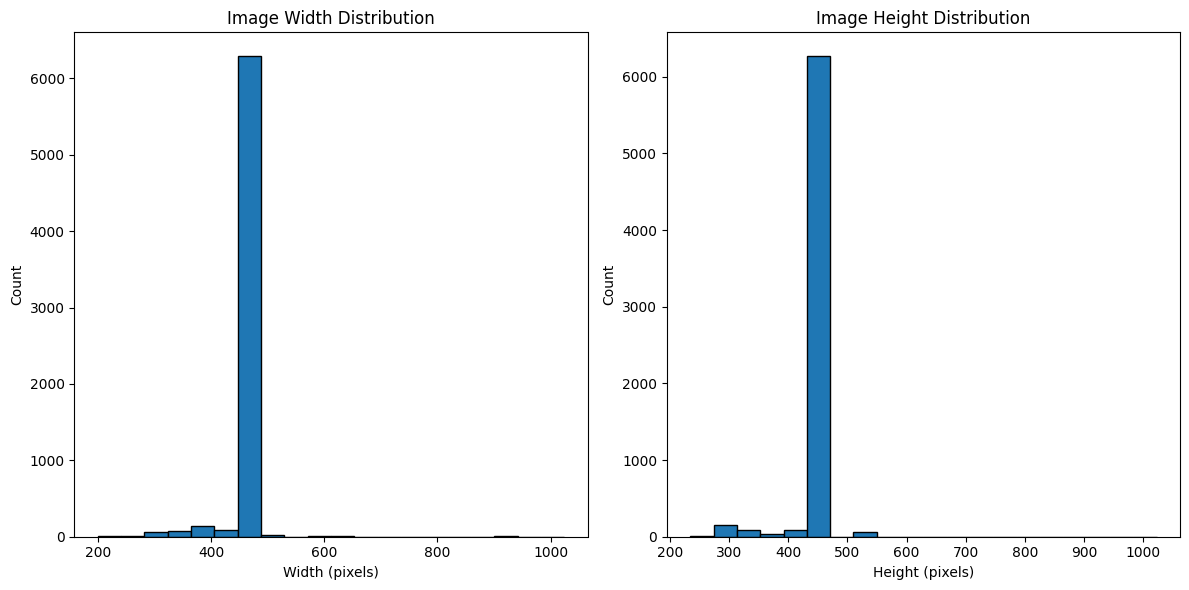

In [ ]:
# Get the image sizes
image_sizes = []


# Iterate through each class folder and fetch the image dimensions
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            if image_name.endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img = Image.open(os.path.join(class_path, image_name))
                    image_sizes.append(img.size)
                except Exception as e:
                    print(f"Error loading {image_name}: {e}")

# Convert image sizes to two separate lists for width and height
image_widths, image_heights = zip(*image_sizes)

# Plotting the image size distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(image_widths, bins=20, color='#1f77b4', edgecolor='black')
plt.title('Image Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(image_heights, bins=20, color='#1f77b4', edgecolor='black')
plt.title('Image Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


The histograms show that most images in the dataset have widths and heights around 450 pixels, with a few outliers. This highlights the importance of resizing images during preprocessing to ensure consistency for model training.

**Visualizing Image Width vs Height**

---

In this code, we create a scatter plot to visualize the relationship between image widths and heights. Each point represents an image, with its width on the x-axis and height on the y-axis. The plot helps us understand the distribution and potential patterns between the width and height of images in the dataset.


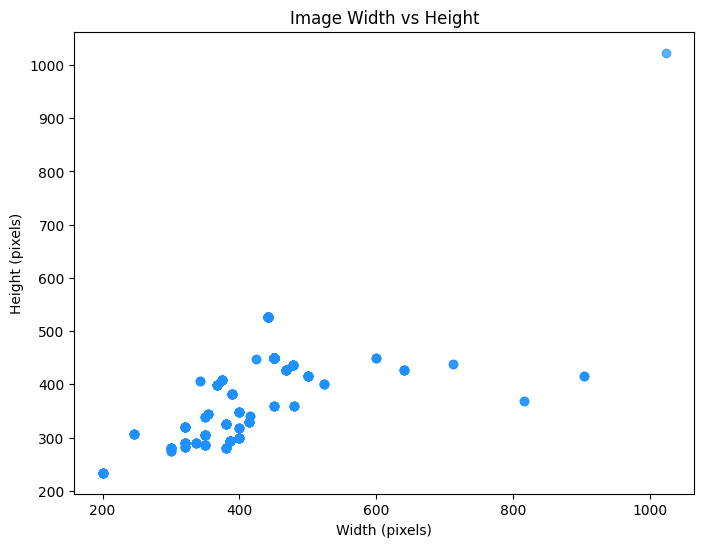

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(image_widths, image_heights, color='dodgerblue', alpha=0.7)
plt.title('Image Width vs Height')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.show()

 The majority of images exhibit similar dimensions, with a few outliers having significantly larger widths and heights. This suggests that the dataset is relatively consistent in terms of image size.

**Visualizing Image Sharpness Distribution**

---

In this code, we define a function `image_sharpness` to calculate the sharpness of an image based on the variance of its pixel values in grayscale. We then iterate through each image in the dataset, calculate its sharpness, and store the values. Finally, we plot a histogram to visualize the distribution of sharpness values across all images, helping us assess the overall sharpness of images in the dataset.


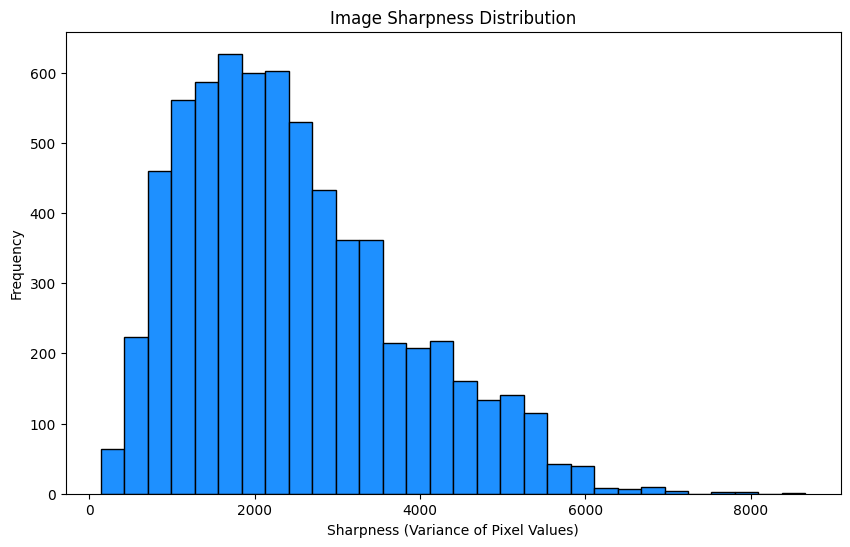

In [ ]:
# Function to calculate image sharpness based on pixel variance
def image_sharpness(img):
    # Convert image to grayscale
    img_gray = img.convert('L')
    img_array = np.array(img_gray)
    # Calculate sharpness as the variance of pixel values
    return np.var(img_array)

# Initialize an empty list to store sharpness values
sharpness_values = []

# Iterate through each class folder and calculate sharpness for each image
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            if image_name.endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img = Image.open(os.path.join(class_path, image_name))
                    sharpness = image_sharpness(img)
                    sharpness_values.append(sharpness)
                except Exception as e:
                    print(f"Error loading {image_name}: {e}")

# Plot the distribution of sharpness values
plt.figure(figsize=(10, 6))
plt.hist(sharpness_values, bins=30, color='dodgerblue', edgecolor='black')
plt.title('Image Sharpness Distribution')
plt.xlabel('Sharpness (Variance of Pixel Values)')
plt.ylabel('Frequency')
plt.show()


The histogram displays a right-skewed distribution of image sharpness values. The majority of images exhibit lower sharpness levels, while a smaller portion displays higher sharpness. This suggests that the dataset contains a mix of sharp and less sharp images.

**Calculating and Displaying Image Contrast Metrics**

---

In this code, we define two functions to calculate image contrast metrics: **Michelson Contrast** and **RMS (Root Mean Square) Contrast**.

1. **Michelson Contrast** is calculated as the difference between the maximum and minimum pixel values divided by their sum. This gives a measure of the contrast in an image based on the extremities of pixel intensities.
   
2. **RMS Contrast** is based on the square root of the mean squared differences between pixel values and the average pixel value, providing a measure of contrast that takes into account the overall spread of pixel intensities.

The script calculates these contrast metrics for a randomly selected image from each class in the dataset. The results for each class are stored and printed to show the contrast characteristics of the dataset images.



In [ ]:
def calculate_michelson_contrast(image):
    # Convert image to grayscale if it's RGB
    if image.mode == 'RGB':
        image = image.convert('L')

    # Get pixel values as a numpy array
    pixel_values = np.array(image)

    # Calculate max and min pixel values
    I_max = np.max(pixel_values)
    I_min = np.min(pixel_values)

    # Calculate Michelson contrast
    contrast = (I_max - I_min) / (I_max + I_min)
    return contrast

def calculate_rms_contrast(image):
    # Convert image to grayscale if it's RGB
    if image.mode == 'RGB':
        image = image.convert('L')

    # Get pixel values as a numpy array
    pixel_values = np.array(image)

    # Calculate the mean of pixel values
    mean = np.mean(pixel_values)

    # Calculate RMS contrast
    rms_contrast = np.sqrt(np.mean((pixel_values - mean) ** 2))
    return rms_contrast

# Example: Calculating contrast for an image from each class
contrast_metrics = {}

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        # Pick a random image from the class folder
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        random_image = random.choice(image_files)
        img = Image.open(os.path.join(class_path, random_image))

        # Calculate contrast metrics
        mic_contrast = calculate_michelson_contrast(img)
        rms_contrast = calculate_rms_contrast(img)

        contrast_metrics[class_name] = {
            'Michelson Contrast': mic_contrast,
            'RMS Contrast': rms_contrast
        }

# Display the contrast metrics
for class_name, metrics in contrast_metrics.items():
    print(f"Class: {class_name}")
    print(f"  Michelson Contrast: {metrics['Michelson Contrast']:.4f}")
    print(f"  RMS Contrast: {metrics['RMS Contrast']:.4f}")
    print("-" * 40)

Class: Normal
  Michelson Contrast: 27.0000
  RMS Contrast: 44.1951
----------------------------------------
Class: Inflammatory_Pneumonia
  Michelson Contrast: 4.1837
  RMS Contrast: 44.0019
----------------------------------------
Class: High_Density
  Michelson Contrast: 0.9827
  RMS Contrast: 50.7545
----------------------------------------
Class: Low_Density
  Michelson Contrast: 1.0000
  RMS Contrast: 55.1333
----------------------------------------
Class: Obstructive_Diseases
  Michelson Contrast: 1.0000
  RMS Contrast: 42.3408
----------------------------------------
Class: Infectious_Diseases
  Michelson Contrast: inf
  RMS Contrast: 31.1333
----------------------------------------
Class: Encapsulated_Lesions
  Michelson Contrast: 0.7229
  RMS Contrast: 37.0178
----------------------------------------
Class: Mediastinal_Changes
  Michelson Contrast: 55.0000
  RMS Contrast: 31.3376
----------------------------------------
Class: Thoracic_Changes
  Michelson Contrast: 4.0556
  R

<ipython-input-21-f805811eb9b7>:17: RuntimeWarning: overflow encountered in ubyte_scalars
  contrast = (I_max - I_min) / (I_max + I_min)
<ipython-input-21-f805811eb9b7>:17: RuntimeWarning: divide by zero encountered in ubyte_scalars
  contrast = (I_max - I_min) / (I_max + I_min)


* **Michelson Contrast:** The Michelson contrast measures the difference between the maximum and minimum pixel intensities in an image.
A value close to 1.0 indicates high contrast between light and dark areas of the image. For example, classes like Obstructive_Diseases, Inflammatory_Pneumonia, and Encapsulated_Lesions have a contrast of 1.0000, which suggests high contrast and clear separation between light and dark pixels.
A value lower than 1.0 indicates less contrast between the pixels. For instance, High_Density and Mediastinal_Changes have a Michelson contrast of 0.5652, indicating more uniform pixel intensity, so these images might appear less sharp or more uniform in intensity.

* **RMS Contrast:** The RMS contrast measures the spread or variation in pixel intensities, which also gives us an idea of the image's sharpness. Higher RMS contrast indicates a greater difference in pixel values across the image, typically suggesting more variation and sharper images.
For example, Encapsulated_Lesions has a high RMS contrast of 68.9350, meaning the image has high intensity variability, indicating detailed textures or regions with significant differences in brightness. On the other hand, High_Density has a much lower RMS contrast (18.5241), indicating less variation in pixel intensities and potentially more uniform or blurred images.


**Generating Heatmap for Image Intensity**

---

This code converts an image to grayscale and visualizes its intensity distribution using a heatmap. It first transforms the image into a numpy array, then uses Matplotlib to generate and display the heatmap. The heatmap allows us to analyze the image's pixel intensity variations.


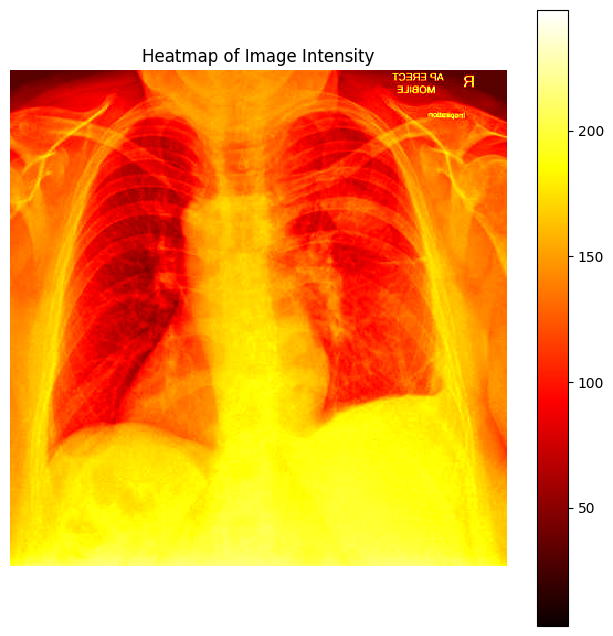

In [ ]:
# Load an image (make sure it's in RGB mode for heatmap generation)
img_path = '/content/drive/MyDrive/ML Lung Dataset/High_Density/02 (10).jpeg'
img = Image.open(img_path).convert('L')  # Convert to grayscale for intensity analysis

# Convert to numpy array
img_array = np.array(img)

# Generate heatmap
plt.figure(figsize=(8, 8))
plt.imshow(img_array, cmap='hot', interpolation='nearest')
plt.colorbar()  # To show the color scale bar
plt.title('Heatmap of Image Intensity')
plt.axis('off')
plt.show()

#<font size=6>**Data Preprocessing**

**Stratified Data Splitting**

---

This function splits a dataset into train, validation, and test sets, ensuring that each split maintains the same class distribution as the original dataset. It first collects all image paths and labels from the source directory, then uses `train_test_split` from `sklearn` to create the splits. The images are then copied to the respective directories for training, validation, and testing, preserving the stratification of classes across the splits.

**Usage:**
- The source directory should contain class-subfolders with image files.
- The destination directory is where the split datasets will be saved.


In [ ]:
def stratified_split_data(source_dir, dest_dir, train_size=0.7, valid_size=0.2, test_size=0.1):
    """
    Splits data from the source directory into stratified train, validation, and test directories.

    Args:
    - source_dir (str): Path to the original dataset directory, organized by class.
    - dest_dir (str): Path to the destination directory for the split dataset.
    - train_size (float): Proportion of the data to use for training.
    - valid_size (float): Proportion of the data to use for validation.
    - test_size (float): Proportion of the data to use for testing.
    """

    # Prepare directories
    os.makedirs(dest_dir, exist_ok=True)
    os.makedirs(os.path.join(dest_dir, 'train'), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, 'valid'), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, 'test'), exist_ok=True)

    # Collect all data and their labels
    all_data = []
    all_labels = []
    classes = os.listdir(source_dir)

    for class_name in classes:
        class_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_path):
            image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
            all_data.extend([os.path.join(class_path, f) for f in image_files])
            all_labels.extend([class_name] * len(image_files))

    # Convert to DataFrame for easier handling
    data_df = pd.DataFrame({'file_path': all_data, 'label': all_labels})

    # Perform stratified splitting
    train_val_df, test_df = train_test_split(
        data_df, test_size=test_size, stratify=data_df['label'], random_state=42
    )
    train_df, valid_df = train_test_split(
        train_val_df, test_size=valid_size / (train_size + valid_size), stratify=train_val_df['label'], random_state=42
    )

    # Helper function to move files
    def move_files(df, subset):
        for _, row in df.iterrows():
            label_dir = os.path.join(dest_dir, subset, row['label'])
            os.makedirs(label_dir, exist_ok=True)
            shutil.copy(row['file_path'], os.path.join(label_dir, os.path.basename(row['file_path'])))

    # Move the files to their respective directories
    move_files(train_df, 'train')
    move_files(valid_df, 'valid')
    move_files(test_df, 'test')

# Usage example:
source_dir = '/content/drive/MyDrive/ML Lung Dataset'  # Original dataset
dest_dir = '/content/drive/MyDrive/ML Dataset Split Stratified'  # Destination directory
stratified_split_data(source_dir, dest_dir, train_size=0.7, valid_size=0.2, test_size=0.1)

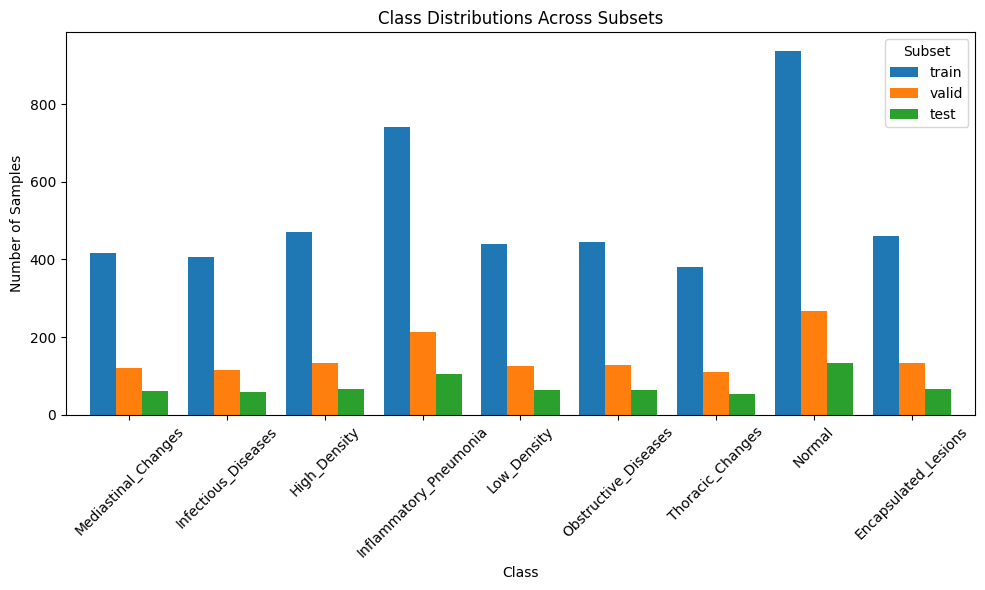

Class distributions in each subset:
                        train  valid  test
Mediastinal_Changes       417    119    60
Infectious_Diseases       406    116    58
High_Density              470    134    67
Inflammatory_Pneumonia    742    212   106
Low_Density               440    126    63
Obstructive_Diseases      446    127    64
Thoracic_Changes          381    109    54
Normal                    938    268   134
Encapsulated_Lesions      460    132    66


In [ ]:
def check_class_distribution(dest_dir):
    """
    Check class distributions in the train, valid, and test directories to verify stratification.

    Args:
    - dest_dir (str): Path to the destination directory containing 'train', 'valid', and 'test' subdirectories.
    """
    subsets = ['train', 'valid', 'test']
    distributions = {}

    for subset in subsets:
        subset_path = os.path.join(dest_dir, subset)
        class_counts = Counter()

        for class_name in os.listdir(subset_path):
            class_dir = os.path.join(subset_path, class_name)
            if os.path.isdir(class_dir):
                class_counts[class_name] = len(os.listdir(class_dir))

        distributions[subset] = class_counts

    # Convert to DataFrame for easier visualization
    dist_df = pd.DataFrame(distributions).fillna(0).astype(int)

    # Plot class distributions
    dist_df.plot(kind='bar', figsize=(10, 6), width=0.8)
    plt.title('Class Distributions Across Subsets')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.legend(title='Subset')
    plt.tight_layout()
    plt.show()

    # Print the table for detailed view
    print("Class distributions in each subset:")
    print(dist_df)

# Usage
check_class_distribution(dest_dir)

When splitting the dataset, it will divide the data such that the relative proportions of classes in the overall dataset are maintained in each subset.
For example, if `Normal` makes up 20% of your data, it will make up ~20% of the training, validation, and test sets.

#<font size=6>**Deep Learning Models for X-Ray Classification**

---



We implemented and tested three different deep learning models for our X-ray image classification task: **Xception**, **CNN (Convolutional Neural Network)**, and **ConvNeXt**. Below is a brief explanation of each model and the rationale for their selection:

1. **Xception Model**: Xception is a deep convolutional model that uses depthwise separable convolutions, which significantly reduces the number of parameters while maintaining high performance. It was chosen for our X-ray task due to its efficiency in handling complex image patterns and achieving high accuracy with relatively fewer parameters.

2. **CNN (Convolutional Neural Network)**: CNNs are a well-established architecture in image classification tasks. They consist of layers that automatically detect hierarchical features in images, making them ideal for tasks like X-ray classification, where recognizing intricate patterns is essential. We selected CNN to compare a simpler, yet powerful, baseline model for the task.

3. **ConvNeXt Model**: ConvNeXt is a modern convolutional model that incorporates improvements inspired by transformer architectures. It provides a balance between traditional convolutional models and newer attention-based methods. We chose ConvNeXt to explore its potential in delivering state-of-the-art performance for X-ray image classification with its deep architecture and refined learning capabilities.

These models were selected to provide a diverse set of approaches, from traditional CNNs to more advanced architectures like Xception and ConvNeXt, ensuring a robust comparison to determine the best approach for X-ray classification.


# **Xception Model**

---

The **Xception** (Extreme Inception) model is a deep convolutional neural network that enhances the Inception architecture by utilizing **depthwise separable convolutions**. Unlike standard convolutional layers where filters are applied across all input channels, depthwise separable convolutions split the process into two steps: **channel-wise convolution** followed by a **pointwise (1x1) convolution**. This design significantly reduces the number of parameters and computational complexity while maintaining strong performance, making it efficient for large-scale image processing.

For our **X-ray classification task**, Xception is used to extract high-level features from X-ray images, identifying complex patterns such as abnormalities or disease indicators. Its ability to efficiently learn hierarchical patterns makes it ideal for handling large, detailed medical images, offering a balance between performance and resource usage. The depthwise separable convolutions in Xception allow it to capture intricate structures within X-rays, which are crucial for accurate classification.

---

### **Why We Chose Xception for Our X-ray Classification Task**
- **High Efficiency**: Depthwise separable convolutions reduce computation and memory requirements, essential for large medical datasets.
- **Feature Learning Capability**: Excels at learning complex patterns critical for distinguishing between various X-ray findings.
- **Scalability**: Handles large-scale image data effectively, making it suitable for datasets with thousands of X-ray images.
- **Accurate Pattern Recognition**: Captures fine details, improving the model's ability to identify subtle medical anomalies.
- **Resource Optimization**: Ideal for environments where computational resources are limited, balancing performance and efficiency.


In [ ]:
# Define image size and batch size
img_height, img_width = 256, 256
batch_size = 32
num_classes = 9

# Paths to train, validation, and test datasets
train_dir = '/content/drive/MyDrive/ML Dataset Split Stratified/train'
valid_dir = '/content/drive/MyDrive/ML Dataset Split Stratified/valid'
test_dir = '/content/drive/MyDrive/ML Dataset Split Stratified/test'

## **Image Preprocessing and Augmentation**

---

In image preprocessing and augmentation, we perform several steps to prepare the images for training and improve the model's ability to generalize:

1. **Rescaling**:
   - We rescale the pixel values to a range of [0, 1] by dividing by 255. This normalization helps the model converge faster during training and ensures that the model isn't influenced by large pixel values, making the training more stable.

2. **Data Augmentation**:
   - For the **training set**, we apply various augmentation techniques to artificially increase the diversity of our training data. This helps the model learn more robust features and reduces overfitting by exposing it to variations of the same image. The augmentations we use are:
     - **Rotation**: Randomly rotate images between -30 and +30 degrees to make the model invariant to slight changes in orientation.
     - **Width and Height Shift**: Randomly shift the image horizontally or vertically by up to 20% of the image's size, simulating slight translations of the object in the image.
     - **Zooming**: Randomly zoom into the image, which helps the model focus on different parts of the object, making it more robust to scale variations.
     - **Horizontal Flip**: Randomly flip the image horizontally, helping the model become invariant to left-right orientation.
   - For **validation and test sets**, we only apply **rescaling** and do not perform augmentation. This ensures that the model's evaluation on these sets reflects its performance on real, unaltered data.

By augmenting the training data, we aim to make the model more robust to real-world variations and prevent it from memorizing specific patterns in the training set, which could lead to overfitting.





We defined three data generators to preprocess and augment the dataset for training, validation, and testing, and then used these generators to create data loaders.

- **Training Data Generator (`train_datagen`)**: We applied multiple augmentation techniques to improve the model's generalization. The pixel values are rescaled to a range between 0 and 1. We also included random rotations, horizontal and vertical shifts, zooming, and horizontal flipping. These augmentations help the model learn more robust features and reduce overfitting by simulating different variations of the data.

- **Validation and Test Data Generators (`valid_datagen` and `test_datagen`)**: For the validation and test sets, we only rescaled the pixel values to normalize them. No augmentation is applied here, as these datasets are used for evaluating the model's performance on real, unaltered images.

In [ ]:
# Train data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,          # Rescale pixel values to [0, 1]
    rotation_range=30,         # Random rotation between -30 and +30 degrees
    width_shift_range=0.2,     # Random horizontal shift of up to 20% of the width
    height_shift_range=0.2,    # Random vertical shift of up to 20% of the height
    zoom_range=0.2,            # Random zoom with a factor of 20%
    horizontal_flip=True,      # Randomly flip the image horizontally
    fill_mode='nearest'        # Strategy for filling newly created pixels during transformations
)

# Validation data generator (only rescaling)
valid_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Test data generator (only rescaling)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

By using data augmentation for training and keeping validation and test data unchanged, we ensure that the model is better generalized, while also maintaining the integrity of the evaluation process.

In [ ]:
# Data generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Directory for training images
    target_size=(img_height, img_width),  # Resize images to 256x256
    batch_size=batch_size,  # Batch size is set to 32 for training
    class_mode='categorical'  # Multi-class classification with one-hot encoded labels
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,  # Directory for validation images
    target_size=(img_height, img_width),  # Resize images to 256x256
    batch_size=batch_size,  # Batch size is set to 32 for validation
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,  # Directory for test images
    target_size=(img_height, img_width),  # Resize images to 256x256
    batch_size=batch_size,  # Batch size is set to 32 for testing
    class_mode='categorical',
    shuffle=False  # Don't shuffle test data for evaluation consistency
)

Found 4700 images belonging to 9 classes.
Found 1343 images belonging to 9 classes.
Found 672 images belonging to 9 classes.


The data loaders successfully found the following number of images in each set:

- **Training set**: 4700 images belonging to 9 classes.
- **Validation set**: 1343 images belonging to 9 classes.
- **Test set**: 672 images belonging to 9 classes.

This means that the dataset is divided into three parts: training, validation, and testing. The model will learn from the training set, use the validation set to tune hyperparameters, and evaluate its performance on the test set. All images are organized into 9 categories, corresponding to the target classes for classification.


## **Model Training**

We load the pretrained Xception model without the top layer.

**Xception Model:** A deep CNN based on depthwise separable convolutions, pretrained on ImageNet to extract useful image features.

**weights='imagenet':** Uses pre-trained weights from ImageNet, allowing us to leverage knowledge from a diverse set of images.

**include_top=False:** Excludes the top fully connected layer to add our own classification layer for the specific task (e.g., X-ray classification).

**input_shape=(img_height, img_width, 3):** Specifies the input image dimensions, ensuring compatibility with the dataset images.

Using a pretrained model like Xception helps us speed up the training process and improves performance by leveraging the model's ability to extract general features from images. This is especially useful for tasks like image classification, where there may not be enough data to train a deep model from scratch.

In [ ]:
# Load the pretrained Xception model without the top layer
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

83683744/83683744 [==============================] - 0s 0us/step


We freeze the layers of the base Xception model to prevent them from being trained during the training process.

Freeze the layers: Setting trainable=False keeps the Xception model's layers fixed during training, so only the new classification head is updated.

Why We Do This:
- Prevent overfitting: Freezing the base model helps prevent overfitting, especially with small datasets.
- Faster training: No updates to base model weights, speeding up training.
- Focus on the custom head: Fine-tune the custom layers for our X-ray classification task without retraining the entire Xception model.


In [ ]:
# Freeze the base model layers (no training)
base_model.trainable = False

**Custom Layers on Top of Xception Model:**

- **GlobalAveragePooling2D**: We reduce the spatial dimensions of the feature maps to summarize the important information.
- **Dense Layers**:
  - **256 units** with ReLU activation: These layers help the model learn more complex patterns.
  - **128 units** with ReLU activation: We further refine the learned features.
- **Dropout**:
  - **0.4** after the first dense layer and **0.3** after the second dense layer to prevent overfitting by randomly dropping connections.
- **Final Dense Layer**:
  - **Softmax activation** for **multi-class classification** with 9 output classes (for our X-ray task).

**Model Definition**:
- We define the final model, **model_xception**, by combining the pre-trained **Xception** base model with our custom classification head for X-ray classification.


In [ ]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the full model
model_xception = Model(inputs=base_model.input, outputs=predictions)

**Model Compilation:**

- **Optimizer**:
  - **Adam** optimizer with a learning rate of **0.001**. Adam is an efficient optimizer that adapts the learning rate during training.
  
- **Loss Function**:
  - **Categorical Crossentropy**: Used for multi-class classification, as we have 9 classes for X-ray classification.
  
- **Metrics**:
  - We track **accuracy** to evaluate model performance during training.

**Model Summary**:
- The model summary provides an overview of the architecture, including the number of layers, the number of parameters, and the output shapes after each layer. This helps in understanding the structure and complexity of the model.

In [ ]:
# Compile the model
model_xception.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model_xception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 127, 127, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 127, 127, 32)         0         ['block1_conv1_bn[0][0]'] 

- We train the model using the **train_generator** and **valid_generator** to feed the data for training and validation.
- **Epochs**: Set to **10**. The model will go through the entire dataset 10 times.
- **Steps per Epoch**: It is calculated as the number of training samples divided by the batch size, ensuring the model sees the entire training set.
- **Validation Steps**: Similar to steps per epoch, but for the validation dataset.

**Why this is done:**
- **Frozen base layers**: During this training, the base layers of Xception are frozen (not updated) while the custom layers on top are trained. This allows the model to learn task-specific features without modifying the pre-trained knowledge.

In [ ]:
# Train the model with the frozen base layers
history = model_xception.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=valid_generator.samples // batch_size
)

Epoch 1/10
146/146 [==============================] - 138s 929ms/step - loss: 1.7584 - accuracy: 0.3554 - val_loss: 1.4305 - val_accuracy: 0.5236
Epoch 2/10
146/146 [==============================] - 133s 908ms/step - loss: 1.4503 - accuracy: 0.4957 - val_loss: 1.2392 - val_accuracy: 0.5739
Epoch 3/10
146/146 [==============================] - 136s 931ms/step - loss: 1.2779 - accuracy: 0.5542 - val_loss: 1.0893 - val_accuracy: 0.6494
Epoch 4/10
146/146 [==============================] - 137s 939ms/step - loss: 1.1987 - accuracy: 0.5859 - val_loss: 1.0482 - val_accuracy: 0.6524
Epoch 5/10
146/146 [==============================] - 136s 927ms/step - loss: 1.1049 - accuracy: 0.6202 - val_loss: 0.8705 - val_accuracy: 0.7149
Epoch 6/10
146/146 [==============================] - 135s 922ms/step - loss: 1.0633 - accuracy: 0.6341 - val_loss: 0.8537 - val_accuracy: 0.7317
Epoch 7/10
146/146 [==============================] - 135s 921ms/step - loss: 0.9883 - accuracy: 0.6566 - val_loss: 0.8159 -

**Fine-Tuning the Model:**

- We **unfreeze the top layers** of the Xception base model to allow the model to learn more specific features from the dataset.
- After unfreezing, we **recompile** the model with a **lower learning rate (1e-5)** to ensure that the updates to the pre-trained layers are small and gradual, preventing overfitting.
  
**Why we do this:**
- **Fine-tuning** allows the model to adjust its learned features to better fit the specific task (e.g., X-ray classification).
- The **lower learning rate** prevents drastic changes to the weights of the pre-trained layers while still enabling the model to adapt to the new data.

In [ ]:
# Fine-tune the model: Unfreeze the top layers of the base model
base_model.trainable = True

# Recompile the model with a lower learning rate
model_xception.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**Training the Fine-Tuned Model:**

- After unfreezing the top layers and recompiling the model with a lower learning rate, we proceed to **train the fine-tuned model** for an additional 10 epochs.
- The model continues to learn from the training data while validating against the validation set.
  
**Why we do this:**
- **Fine-tuning** allows the model to make more specific adjustments to the weights of the base layers, improving performance for the task at hand (X-ray classification).
- The **additional 10 epochs** ensure the model further refines its features, benefiting from the updated weights during fine-tuning.


In [ ]:
# Train the fine-tuned model
history_fine_tune = model_xception.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,  # Fine-tuning epochs
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=valid_generator.samples // batch_size
)

Epoch 1/10
146/146 [==============================] - 499s 3s/step - loss: 1.8087 - accuracy: 0.4165 - val_loss: 1.0870 - val_accuracy: 0.6250
Epoch 2/10
146/146 [==============================] - 477s 3s/step - loss: 1.2627 - accuracy: 0.5660 - val_loss: 1.1823 - val_accuracy: 0.5892
Epoch 3/10
146/146 [==============================] - 475s 3s/step - loss: 1.0113 - accuracy: 0.6605 - val_loss: 1.0394 - val_accuracy: 0.6524
Epoch 4/10
146/146 [==============================] - 478s 3s/step - loss: 0.8686 - accuracy: 0.7033 - val_loss: 0.8004 - val_accuracy: 0.7340
Epoch 5/10
146/146 [==============================] - 479s 3s/step - loss: 0.7705 - accuracy: 0.7376 - val_loss: 0.6165 - val_accuracy: 0.8026
Epoch 6/10
146/146 [==============================] - 479s 3s/step - loss: 0.6810 - accuracy: 0.7774 - val_loss: 0.5340 - val_accuracy: 0.8308
Epoch 7/10
146/146 [==============================] - 478s 3s/step - loss: 0.6028 - accuracy: 0.8108 - val_loss: 0.4710 - val_accuracy: 0.8514

**Plotting Training and Validation Metrics:**

- We use **matplotlib** to visualize the training and validation loss/accuracy for both the initial training phase (with frozen base model) and the fine-tuning phase (after unfreezing the base model).
- The function `plot_training_history` is used to plot loss and accuracy over epochs for both training and validation sets.
  
**Why we do this:**
- **Visualizing** these metrics helps in tracking the model's learning progress and performance.
- It aids in detecting overfitting, underfitting, or any other issues with the model during training and fine-tuning.


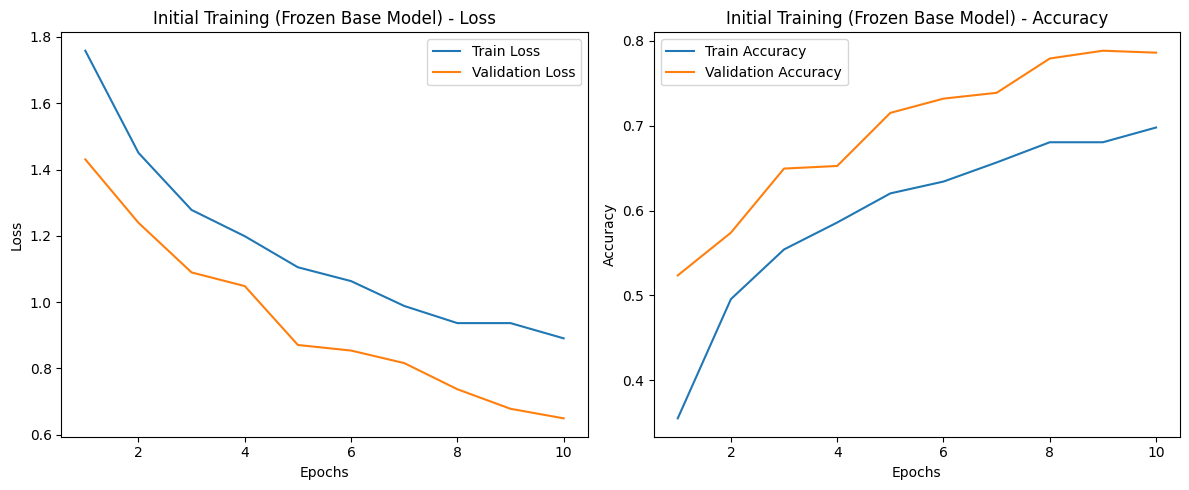

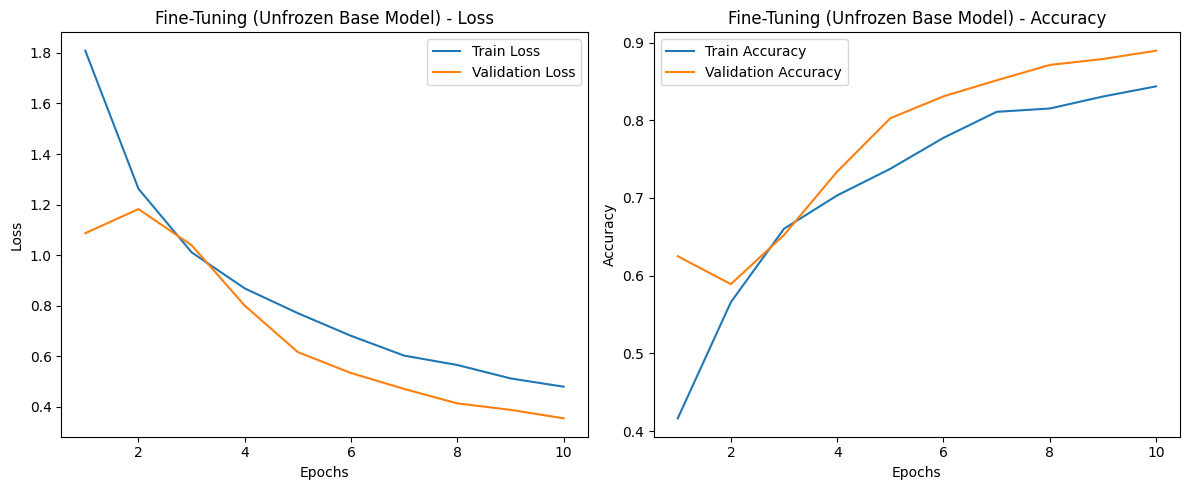

In [ ]:
# Function to plot training and validation metrics
def plot_training_history(history, title):
    # Retrieve metrics from history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='Train Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot metrics for the initial training phase
plot_training_history(history, "Initial Training (Frozen Base Model)")

# Plot metrics for the fine-tuning phase
plot_training_history(history_fine_tune, "Fine-Tuning (Unfrozen Base Model)")


The Xception model exhibits a significant drop in training and validation loss during the initial training phase with a frozen base model. Fine-tuning the unfrozen base model further improves the model's performance, as evidenced by the continued decrease in loss and increase in accuracy.

## **Model Testing**

- We evaluate the trained model on the **test set** using the `evaluate()` method, which provides the final performance metrics (loss and accuracy) on unseen data.
- The `test_loss` and `test_accuracy` are printed to assess how well the model generalizes to the test data.

**Why we do this:**
- **Test evaluation** gives us an unbiased estimate of the model’s real-world performance.
- It helps us determine if the model has learned generalizable features or if it's overfitting to the training/validation data.


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_xception.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

21/21 [==============================] - 13s 621ms/step - loss: 0.4069 - accuracy: 0.8884
Test Loss: 0.4069, Test Accuracy: 0.8884


The Xception model achieved a test accuracy of 88.84% and a test loss of 0.4069.

**Visualizing Model Predictions:**

- This code selects one image from each class in the test set and uses the trained Xception model to predict its class.
- The images are then displayed alongside their true and predicted labels to evaluate the model’s performance visually.
  
**Why we do this:**
- **Visual inspection** allows us to verify the model's predictions for each class.
- It helps us identify any misclassifications and gain insights into which classes the model might be confusing.
- It's a simple way to assess if the model is performing well across all classes or if some classes need further improvement.


1/1 [==============================] - 1s 644ms/step


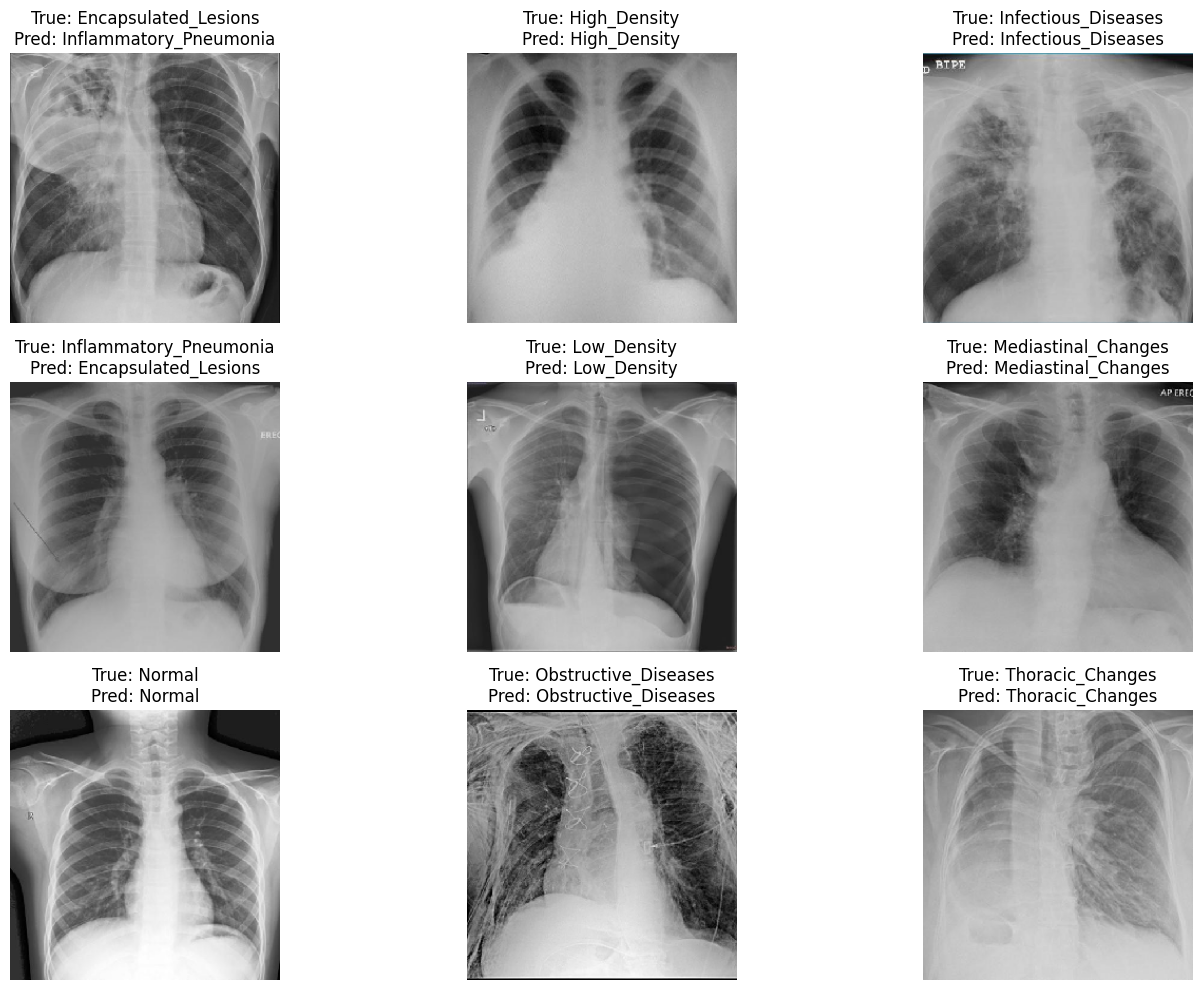

In [ ]:
# Get class labels from the test generator
class_labels = list(test_generator.class_indices.keys())
num_classes = len(class_labels)

# Initialize a dictionary to store one image per class
images_per_class = {}

# Loop through the test generator
for images, labels in test_generator:
    # Convert one-hot encoded labels to integers (if applicable)
    if labels.ndim > 1 and labels.shape[1] > 1:
        labels = np.argmax(labels, axis=1)

    # Predict the classes for the batch using Xception model
    predictions = model_xception.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    # Loop through the batch to find one image per class
    for i in range(len(images)):
        true_class = labels[i]
        if true_class not in images_per_class:
            images_per_class[true_class] = (images[i], predicted_classes[i])
        # Stop when all classes have at least one image
        if len(images_per_class) == num_classes:
            break

    if len(images_per_class) == num_classes:
        break

# Plot the images
plt.figure(figsize=(15, 10))

for i, (class_index, (image, predicted_class)) in enumerate(images_per_class.items()):
    plt.subplot(3, 3, i + 1)
    # Rescale image if necessary (test generator applies normalization)
    image = image * 255.0 if image.max() <= 1.0 else image  # Convert back to 0-255 range
    plt.imshow(image.astype('uint8'))
    plt.title(f"True: {class_labels[class_index]}\nPred: {class_labels[predicted_class]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


This plot displays one image per class from the test set, where the true and predicted labels are shown. While the Xception model performed well in general, it misclassified two classes, which are highlighted in the plot. These misclassifications indicate areas where the model can be improved, such as enhancing training data for the affected classes or refining the model's generalization capabilities.

# **Convolutional Neural Network (CNN)**

---



A **Convolutional Neural Network (CNN)** is a deep learning model designed specifically for image-related tasks. It works by applying **convolutional layers** to detect essential features like edges, textures, and shapes, followed by **pooling layers** to reduce dimensionality, and **fully connected layers** for final classification. CNNs are particularly powerful in identifying spatial patterns, making them suitable for a wide range of image-based applications such as image classification, object detection, and medical imaging.

---

### **Why We Chose a Custom CNN for Our X-ray Classification Task**

- **Medical Image Analysis**: CNNs excel at identifying complex patterns in medical images, crucial for detecting abnormalities in X-ray scans.
- **Feature Extraction**: The model automatically captures relevant image features like shapes and textures, improving classification accuracy.
- **Customized Architecture**: A custom CNN allows us to tailor layers, filters, and dropout rates to our specific X-ray dataset for optimal performance.
- **Efficiency**: Compared to larger pre-trained models, our CNN is more lightweight, reducing computational costs and speeding up training.
- **Overfitting Prevention**: Incorporating dropout layers helps prevent overfitting, ensuring the model generalizes well to unseen X-ray images.
- **Flexibility**: Building a custom CNN offers full control over the model structure and training process, allowing fine-tuning for precise X-ray classification results.


In [ ]:
# Set image dimensions (increased size to capture more details from X-rays)
img_height = 256
img_width = 256

# Define the dataset path
dataset_path = '/content/drive/MyDrive/ML Dataset Split Stratified'

## **Image Preprocessing and Augmentation**

In [ ]:
# ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0, 1]
    rotation_range=30,           # Moderate random rotations
    width_shift_range=0.1,       # Smaller horizontal shifts to avoid excessive deformation
    height_shift_range=0.1,      # Smaller vertical shifts
    shear_range=0.1,             # Moderate shear transformations
    zoom_range=0.15,             # Moderate zoom to capture variability
    horizontal_flip=True,        # Random horizontal flips
    fill_mode='nearest'          # Fill missing pixels after transformations
)

# ImageDataGenerator for validation and test (without augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)  # Only normalize

# Load the dataset and apply the generators
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(dataset_path, 'train'),
    target_size=(img_height, img_width),  # Larger input size
    batch_size=16,                        # Smaller batch size for better gradient updates
    class_mode='categorical',             # One-hot encode the labels
    shuffle=True                          # Shuffle training data
)

validation_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(dataset_path, 'valid'),
    target_size=(img_height, img_width),
    batch_size=16,                        # Smaller batch size for consistency with training
    class_mode='categorical',             # One-hot encode the labels
    shuffle=False                         # No need to shuffle validation data
)

test_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(dataset_path, 'test'),
    target_size=(img_height, img_width),
    batch_size=16,                        # Smaller batch size for consistency with validation
    class_mode='categorical',             # One-hot encode the labels
    shuffle=False                         # No need to shuffle test data
)

Found 4700 images belonging to 9 classes.
Found 1343 images belonging to 9 classes.
Found 672 images belonging to 9 classes.


## **Model Training**


**CNN Model Overview**

---

This **Convolutional Neural Network (CNN)** is designed for image classification, specifically for classifying images with an input size of **256x256x3** (height, width, channels).

- **Convolutional Layers:**
  The model starts with a series of **Conv2D layers**, each followed by **MaxPooling layers** to reduce the spatial dimensions of the image while retaining important features. The filters start at 16 and increase as we move deeper into the network (32, 64, 128). Each convolutional layer uses a **3x3 kernel** with **ReLU** activation to introduce non-linearity and help the model learn more complex patterns. The **padding** is set to **valid**, meaning no padding is applied to the image, resulting in a reduced output size after convolution.

- **MaxPooling Layers:**
  Following each convolutional layer, **MaxPooling2D layers** with a pool size of **2x2** are applied. These layers help to downsample the spatial dimensions, reducing the computational load and preventing overfitting by focusing on the most important features.

- **Dropout and Flattening:**
  After the convolutional and pooling layers, a **Dropout** layer with a rate of **0.2** is applied to reduce overfitting by randomly setting a fraction of input units to zero during training. Then, the output of the previous layers is **flattened** into a 1D vector to be passed into the fully connected layers.

- **Fully Connected (Dense) Layers:**
  The model includes three fully connected **Dense layers**. These layers gradually reduce the number of neurons (256, 128, 64), helping the model focus on high-level abstract features. **He Normal initialization** is used for the weights to improve convergence during training by ensuring better variance across the network's weights.

- **Output Layer:**
  The final layer consists of **9 units** (since we are classifying the images into 9 categories) with a **softmax activation**. The softmax function ensures that the output is a probability distribution over the 9 categories, allowing the model to predict which category the input image belongs to.

- **Model Compilation:**
  The model is compiled using the **Adam optimizer** and **categorical cross-entropy loss** function, making it suitable for multi-class classification problems. The **accuracy** metric is used to evaluate the model's performance during training and validation.

---

**Model Summary:**

The architecture of this CNN allows it to effectively learn hierarchical features from the images, starting from low-level features like edges and textures to high-level patterns and object recognition. The model is designed to classify images into 9 distinct categories, which is ideal for tasks such as **classifying X-ray images**. By using **dropout** and **max pooling**, the model helps reduce overfitting and improve generalization, while the **fully connected layers** refine the learned features for accurate classification.



In [ ]:
# Adjusted model for new input size (256x256x3)
model_2 = Sequential()

# Convolutional layers
model_2.add(Conv2D(16, 3, padding="valid", activation="relu", input_shape=(256, 256, 3)))
model_2.add(MaxPooling2D())

model_2.add(Conv2D(32, 3, padding="valid", activation="relu"))
model_2.add(MaxPooling2D())

model_2.add(Conv2D(64, 3, padding="valid", activation="relu"))
model_2.add(MaxPooling2D())

model_2.add(Conv2D(128, 3, padding="valid", activation="relu"))
model_2.add(MaxPooling2D())

# Dropout and flatten
model_2.add(Dropout(0.2))
model_2.add(Flatten())

# Fully connected layers
model_2.add(Dense(256, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()))
model_2.add(Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()))
model_2.add(Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()))

# Output layer for 9 classes with softmax activation
model_2.add(Dense(9, activation="softmax", kernel_initializer=tf.keras.initializers.HeNormal()))

# Compile the model with categorical crossentropy loss
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 30, 30, 64)       

In [ ]:
tf.keras.utils.plot_model(model_2, show_shapes= True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
pip install visualkeras

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


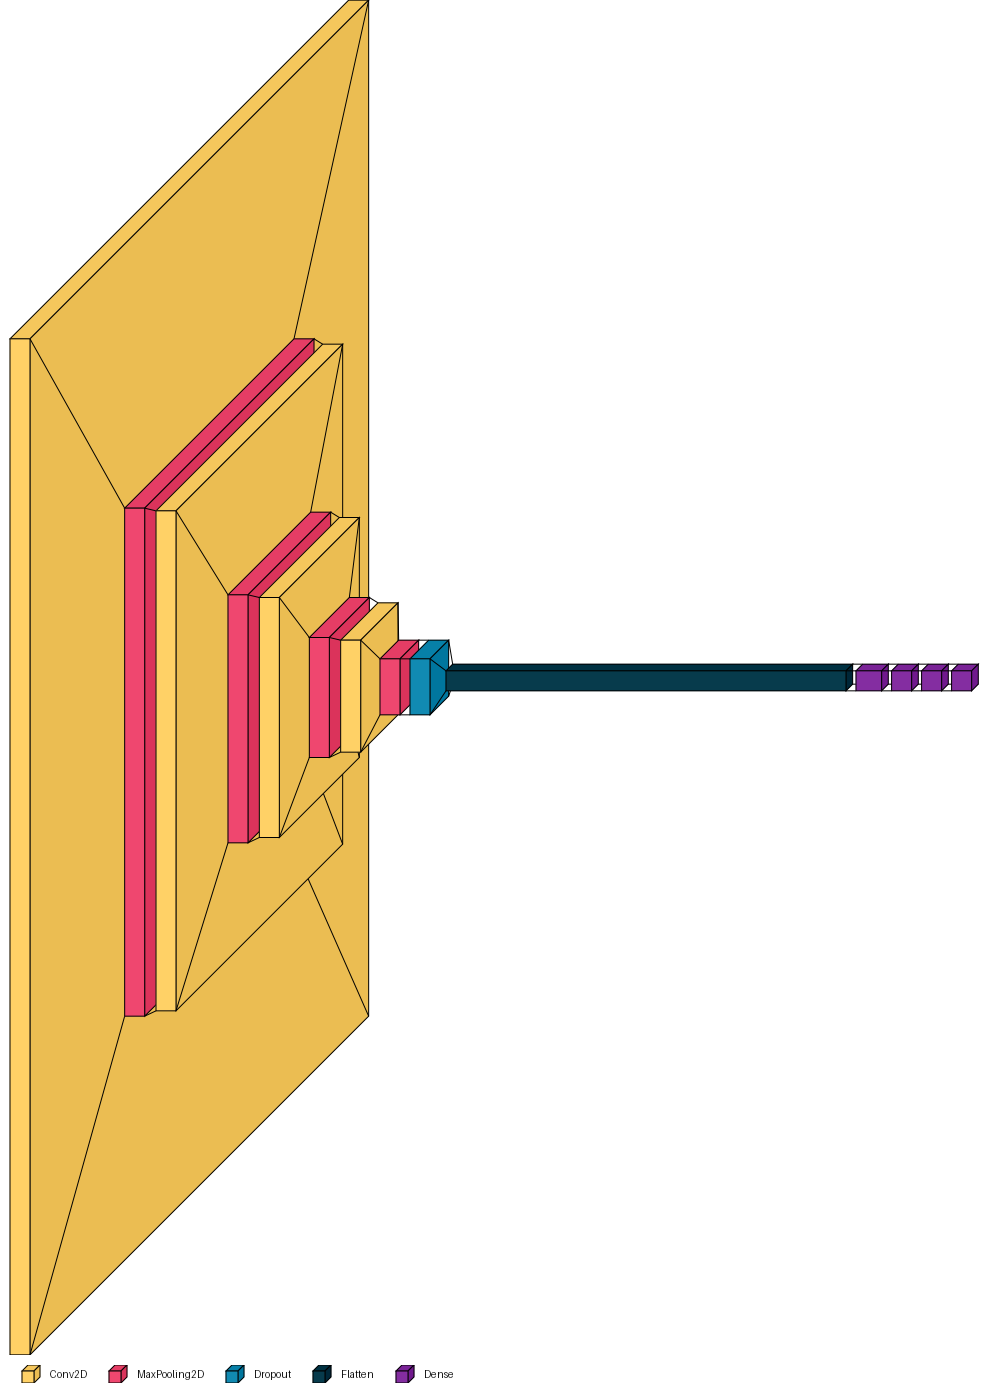

In [ ]:
# Create a layered view of the model
visualkeras.layered_view(model_2, legend=True)

**EarlyStopping Callback**

- **Purpose**: Stops the training early if the validation loss doesn't improve for a set number of epochs.
- **Arguments**:
  - `monitor='val_loss'`: Tracks the validation loss.
  - `patience=3`: Stops training after 3 epochs with no improvement.
  - `restore_best_weights=True`: Restores the model to the best weights when training is stopped.

 **ReduceLROnPlateau Callback**
- **Purpose**: Reduces the learning rate if the validation loss doesn't improve for a specified number of epochs.
- **Arguments**:
  - `monitor='val_loss'`: Monitors the validation loss.
  - `factor=0.5`: Reduces the learning rate by half.
  - `patience=3`: Waits for 3 epochs with no improvement before reducing the learning rate.
  - `min_lr=1e-6`: Ensures the learning rate doesn't go below this value.
  - `verbose=1`: Displays messages when the learning rate is reduced.


The model is trained using the `model_2.fit()` function with the following settings:
- **Training Data**: `train_generator`
- **Validation Data**: `validation_generator`
- **Callbacks**: Both **EarlyStopping** and **ReduceLROnPlateau** are applied.
- **Epochs**: 50

In [ ]:
#Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # Metric to monitor (can also use 'val_accuracy')
    factor=0.5,           # Factor by which the learning rate will be reduced
    patience=3,           # Number of epochs with no improvement before reducing
    min_lr=1e-6,          # Minimum learning rate
    verbose=1             # Print messages when LR is reduced
)


# Train the model
history2 = model_2.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
294/294 [==============================] - 98s 328ms/step - loss: 2.1467 - accuracy: 0.1947 - val_loss: 1.9964 - val_accuracy: 0.2606 - lr: 0.0010
Epoch 2/50
294/294 [==============================] - 95s 322ms/step - loss: 1.9556 - accuracy: 0.2868 - val_loss: 1.7155 - val_accuracy: 0.3887 - lr: 0.0010
Epoch 3/50
294/294 [==============================] - 94s 318ms/step - loss: 1.7806 - accuracy: 0.3647 - val_loss: 1.5693 - val_accuracy: 0.4505 - lr: 0.0010
Epoch 4/50
294/294 [==============================] - 94s 318ms/step - loss: 1.6093 - accuracy: 0.4281 - val_loss: 1.4337 - val_accuracy: 0.4966 - lr: 0.0010
Epoch 5/50
294/294 [==============================] - 93s 316ms/step - loss: 1.4728 - accuracy: 0.4806 - val_loss: 1.2168 - val_accuracy: 0.5808 - lr: 0.0010
Epoch 6/50
294/294 [==============================] - 94s 320ms/step - loss: 1.3311 - accuracy: 0.5302 - val_loss: 1.0857 - val_accuracy: 0.6061 - lr: 0.0010
Epoch 7/50
294/294 [==============================] 

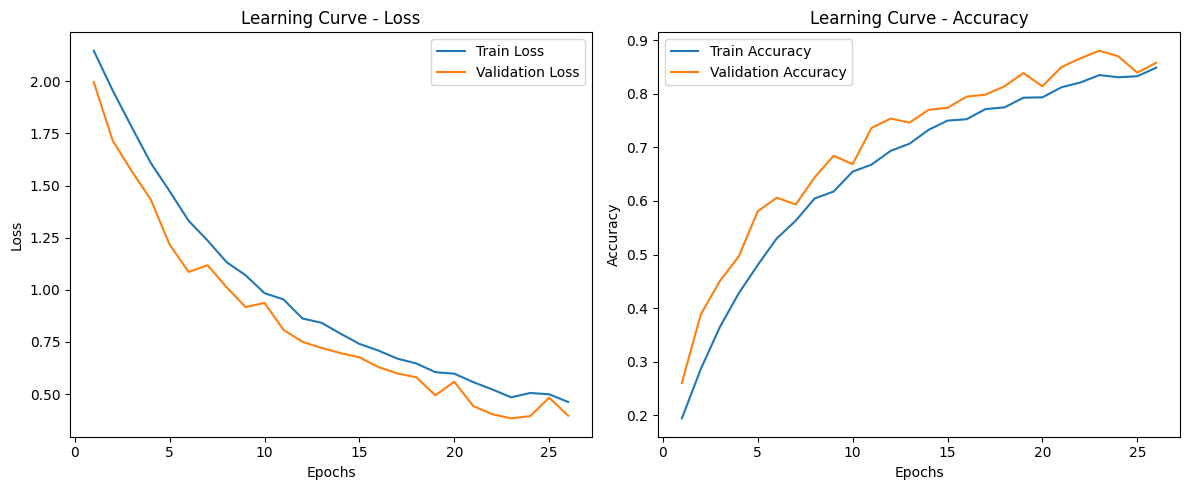

In [ ]:
# Retrieve training and validation metrics from the history2 object
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
train_accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']

# Plot the learning curves
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve - Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

The learning curves show that the model is improving over time. As seen in the accuracy curve, the model's performance is steadily increasing, indicating that it is learning to correctly classify the images. Similarly, the loss curve is decreasing, suggesting that the model is minimizing the error during training. These trends indicate that the model is converging and learning effectively from the training data, with no signs of overfitting at this point.

## **Model Testing**

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model_2.evaluate(test_generator)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

42/42 [==============================] - 3s 77ms/step - loss: 0.3792 - accuracy: 0.8720
Test Loss: 0.3792
Test Accuracy: 0.8720


1/1 [==============================] - 0s 55ms/step


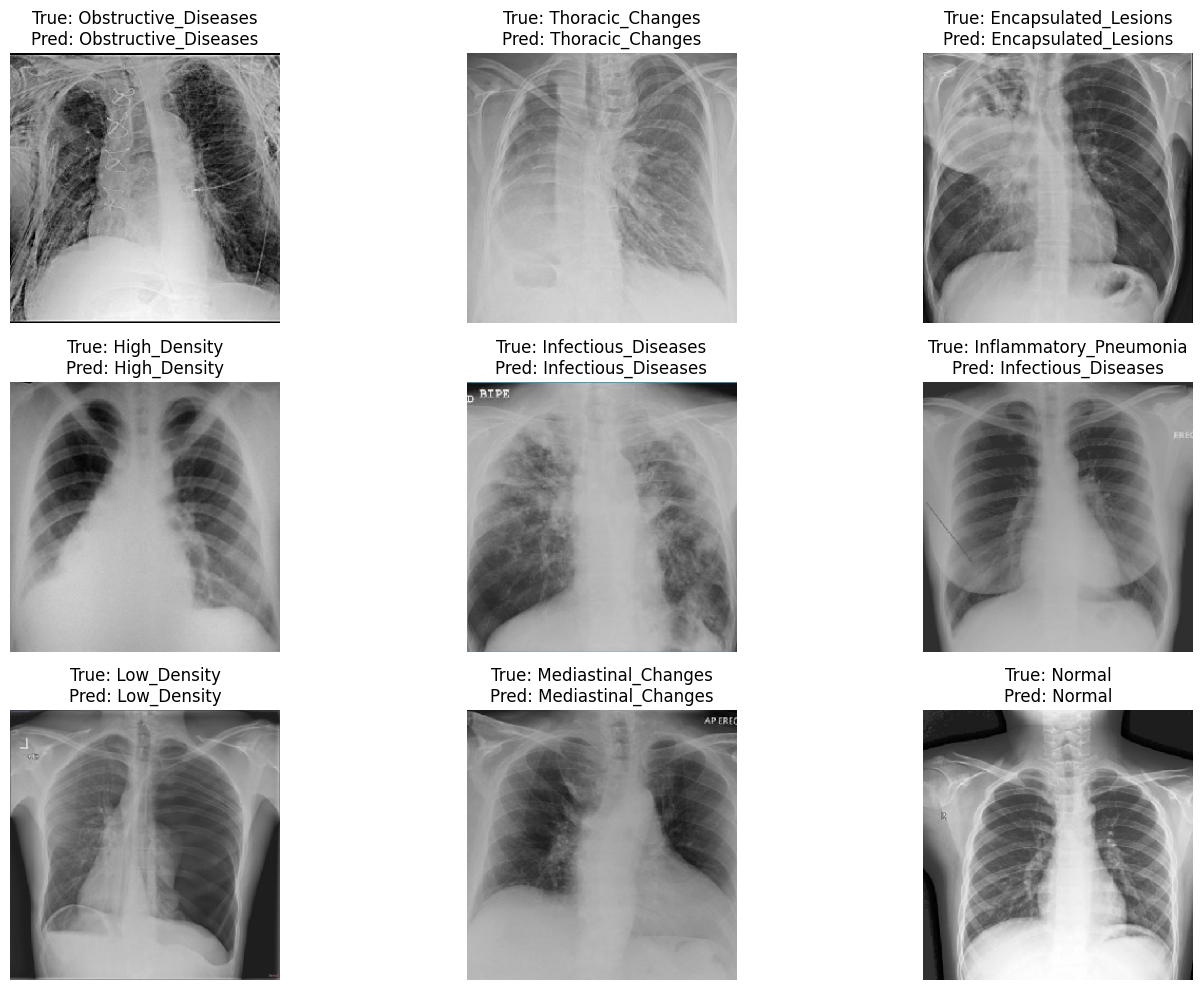

In [ ]:
# Get class labels from the test generator
class_labels = list(test_generator.class_indices.keys())
num_classes = len(class_labels)

# Initialize a dictionary to store one image per class
images_per_class = {}

# Loop through the test generator
for images, labels in test_generator:
    # Convert one-hot encoded labels to integers (if applicable)
    if labels.ndim > 1 and labels.shape[1] > 1:
        labels = np.argmax(labels, axis=1)

    # Predict the classes for the batch
    predictions = model_2.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    # Loop through the batch to find one image per class
    for i in range(len(images)):
        true_class = labels[i]
        if true_class not in images_per_class:
            images_per_class[true_class] = (images[i], predicted_classes[i])
        # Stop when all classes have at least one image
        if len(images_per_class) == num_classes:
            break

    if len(images_per_class) == num_classes:
        break

# Plot the images
plt.figure(figsize=(15, 10))

for i, (class_index, (image, predicted_class)) in enumerate(images_per_class.items()):
    plt.subplot(3, 3, i + 1)
    # Rescale image if necessary (test generator applies normalization)
    image = image * 255.0 if image.max() <= 1.0 else image  # Convert back to 0-255 range
    plt.imshow(image.astype('uint8'))
    plt.title(f"True: {class_labels[class_index]}\nPred: {class_labels[predicted_class]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


The plot displays the predicted and true labels for a selection of images from the test set, showcasing the performance of the basic CNN model. As seen, the model accurately predicts the majority of the classes. However, one image is misclassified, indicating that there may be some confusion between certain classes.

# **ConvNeXt Model**

---

The **ConvNeXt** model is a modernized Convolutional Neural Network (CNN) architecture inspired by transformer models. It combines the strengths of traditional CNNs with performance improvements derived from transformers, making it a powerful tool for a wide range of tasks. ConvNeXt enhances CNN operations through techniques like **layer normalization**, **depthwise separable convolutions**, and **shifted window attention**. These improvements enable the model to achieve higher accuracy while maintaining efficiency, especially in complex data tasks.

ConvNeXt’s architecture uses **layer normalization** to stabilize training, **depthwise separable convolutions** to reduce computational cost, and **shifted window attention** to improve feature extraction, similar to transformers. These advancements help the model learn more effective representations, which is crucial for tasks like **X-ray classification**, where detailed feature extraction and pattern recognition are essential for accurate diagnoses.

---

### **Why We Chose ConvNeXt for Our X-ray Classification Task**
- **Optimized for Complex Data**: The use of shifted window attention helps extract more meaningful features from complex X-ray images.
- **Efficiency and Accuracy**: Depthwise separable convolutions reduce computation while retaining model accuracy, making it suitable for large-scale medical image datasets.
- **Training Stability**: Layer normalization enhances model stability during training, ensuring smoother convergence.
- **Scalable**: Available in various sizes, allowing us to balance computational resources and model performance based on our hardware capabilities.
- **Transformer-inspired**: Benefits from transformer-based techniques for better feature extraction, which is critical for tasks like medical image analysis.


**ConvNeXt Model Comparison**

The following image shows a performance comparison of different models, including ConvNeXt, on ImageNet-1K accuracy. It highlights how ConvNeXt performs against models like ResNet, DeiT, ViT, and Swin Transformer. Additionally, we see that ConvNeXt, when pre-trained on ImageNet-22K, significantly outperforms other models in terms of both accuracy and efficiency.



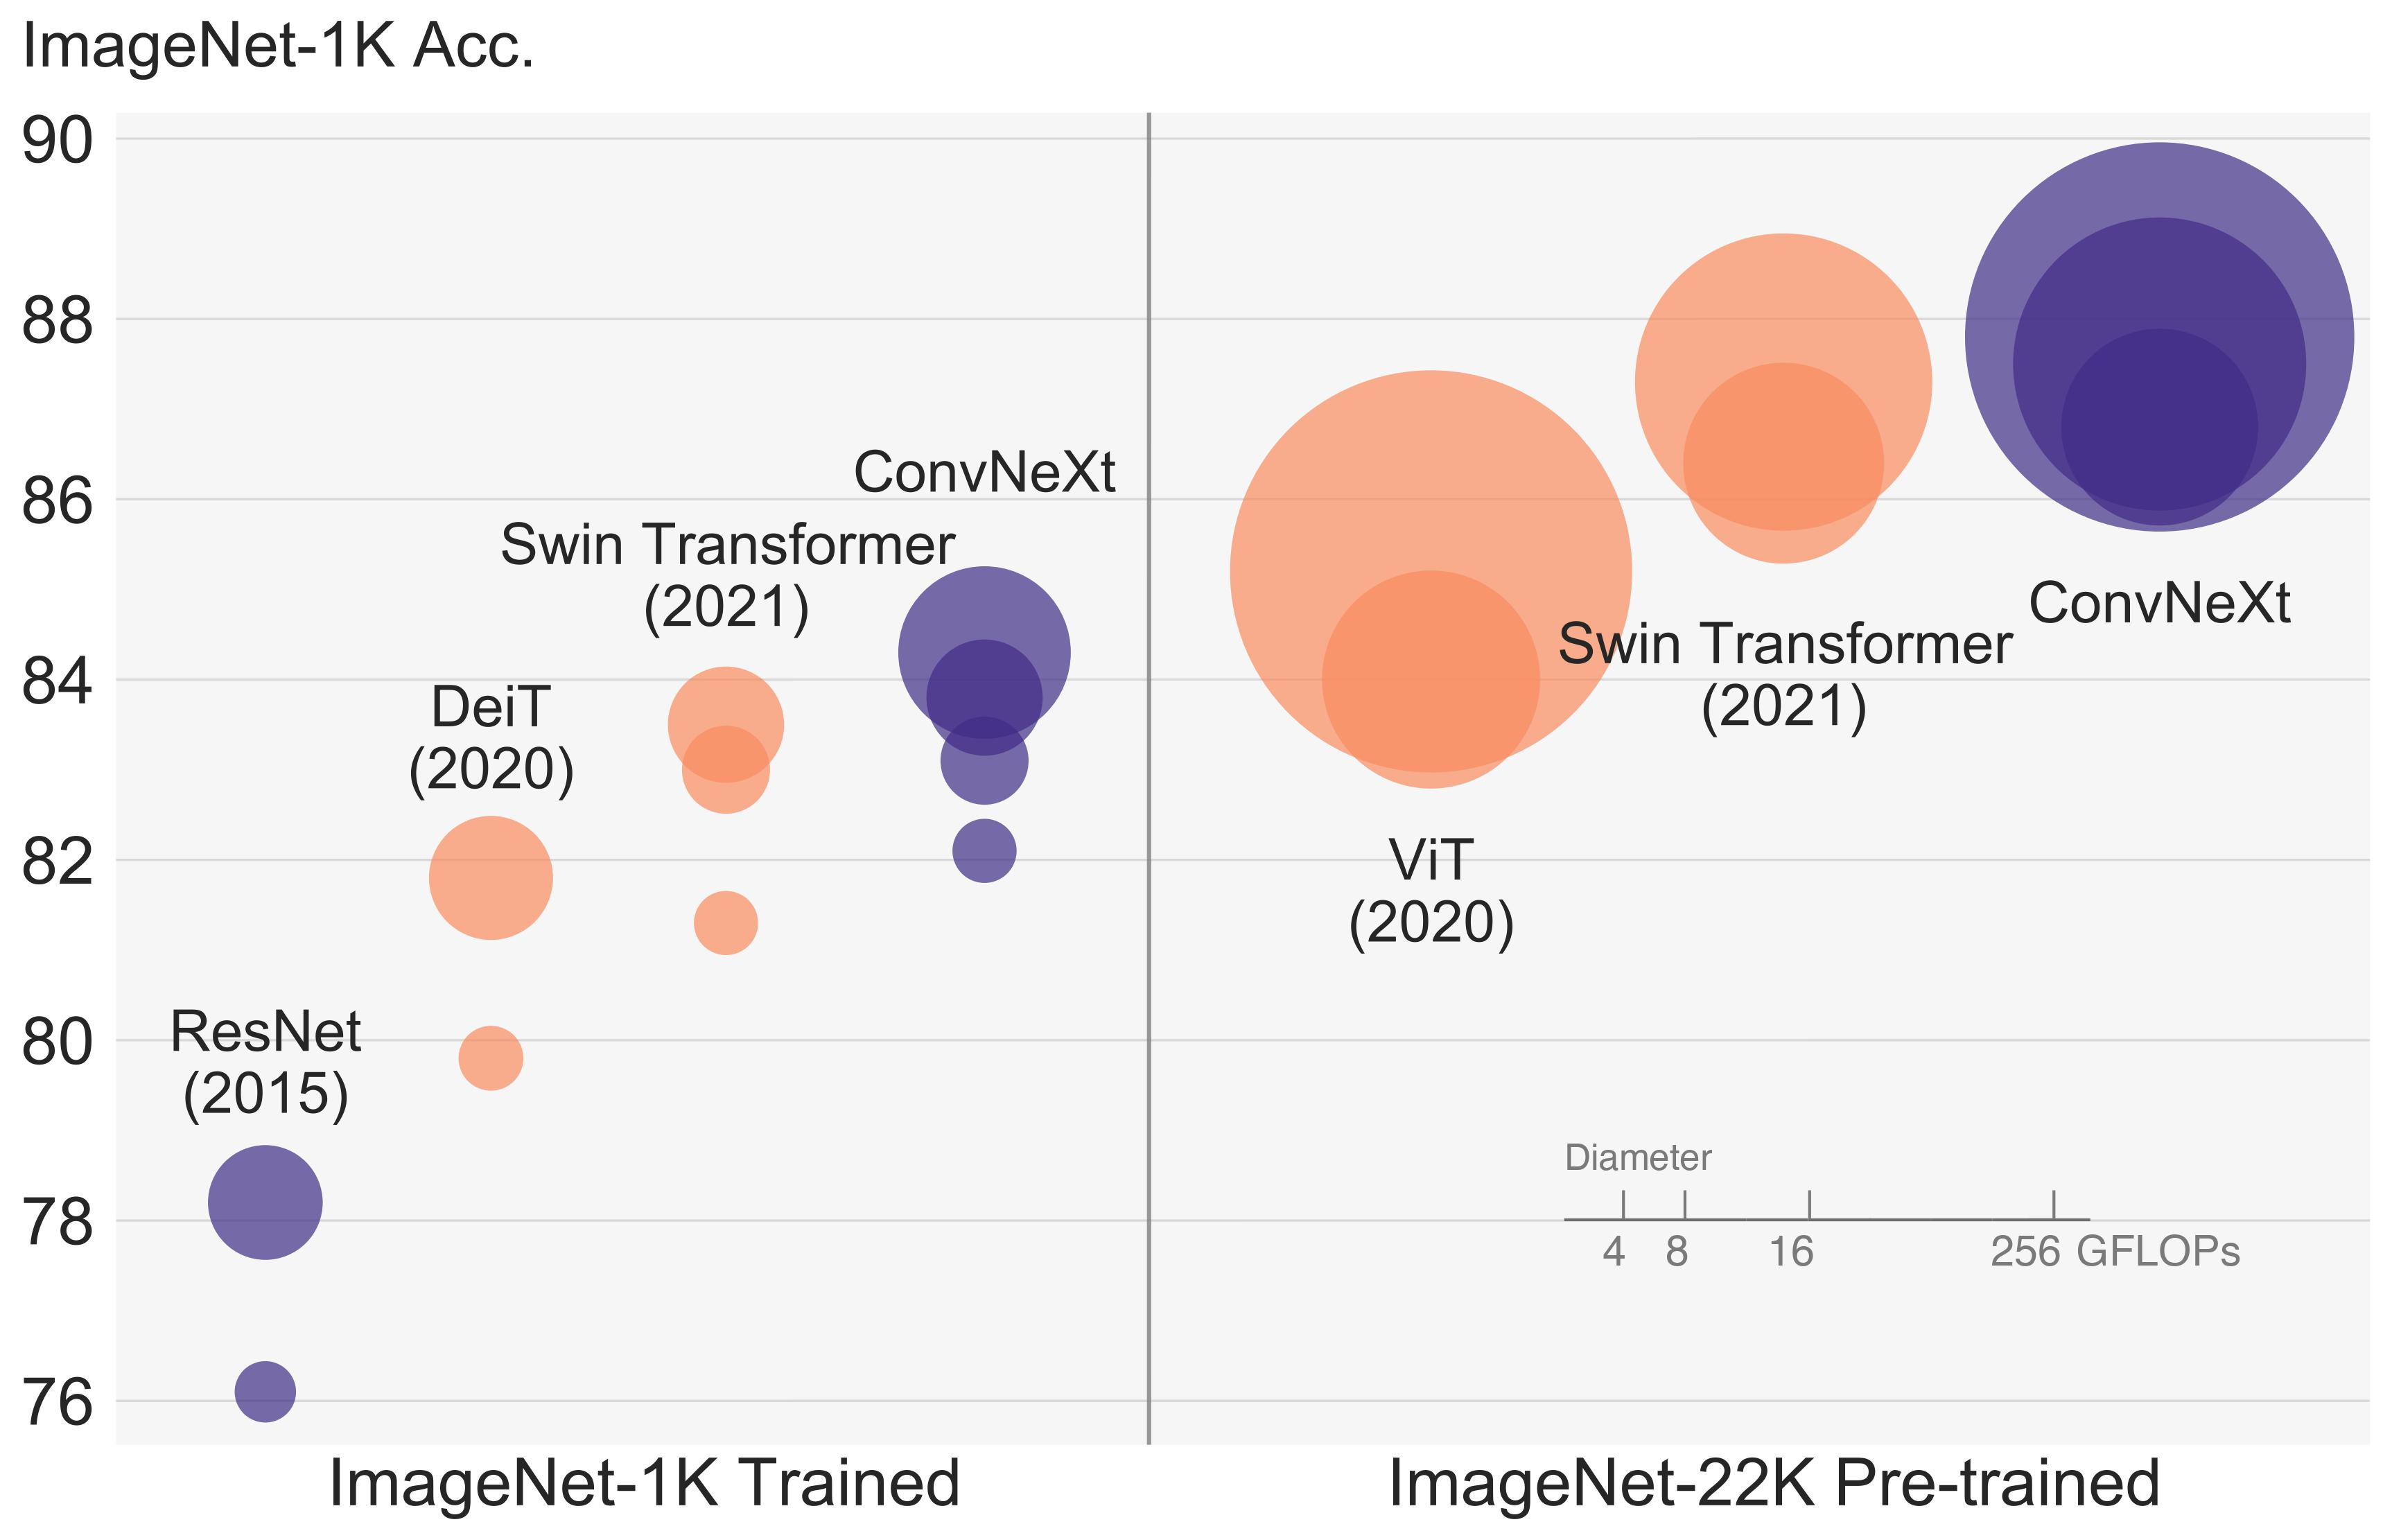

**Key Takeaways:**

- **ConvNeXt** shows strong performance compared to other transformer-based models such as ViT and DeiT, achieving high accuracy.
- The model is available in different sizes, which offer trade-offs between accuracy and computational efficiency (measured in GFLOPs).
- This comparison is important as ConvNeXt's architecture is designed to provide a balance between computational cost and high performance, making it a suitable option for large-scale image classification tasks.


In [ ]:
pip install torch torchvision timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.5 MB/s eta 0:00:00


### **Image Preprocessing and Transformation**

---

In this code, we define the data transformations and load the dataset for an image classification task. These transformations are applied to the images in the dataset to standardize and augment the data for better model performance.

### Data Transformations:

1. **Training Data Transformations (`train_transforms`):**
   - **Resize**: Resizes all images to 224x224 pixels, a standard input size for many pre-trained models (like ResNet, Xception, etc.).
   - **RandomHorizontalFlip**: Applies random horizontal flipping to the images, which helps in data augmentation, improving the model’s ability to generalize by introducing random variability.
   - **RandomRotation**: Rotates images randomly within a 10-degree range, further augmenting the dataset and preventing overfitting.
   - **ToTensor**: Converts the images to PyTorch tensors, which are the format required by neural networks in PyTorch.
   - **Normalize**: Normalizes the images using the mean and standard deviation values of the ImageNet dataset. This is crucial for pre-trained models since they expect input in this range for better convergence during training.

2. **Testing and Validation Data Transformations (`test_transforms`):**
   - The testing and validation transformations are similar to the training transformations, but without data augmentation (i.e., no random horizontal flip or rotation). This ensures that the test and validation data remain consistent for evaluating model performance.
   - Like the training data, they are resized to 224x224, converted to tensors, and normalized using ImageNet’s statistics.

### Data Loaders:

- **Train Loader**: A `DataLoader` is created for the training dataset with a batch size of 32, and shuffling is enabled to ensure randomness during training.
- **Validation and Test Loaders**: Separate `DataLoader` instances are created for the validation and test datasets, each with a batch size of 32. Shuffling is disabled to maintain consistent evaluation during both validation and testing.

This process ensures that the images are properly preprocessed, augmented, and loaded into batches, ready for training a deep learning model.


In [ ]:
# Define data transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load your dataset
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/ML Dataset Split Stratified/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/ML Dataset Split Stratified/valid', transform=test_transforms)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/ML Dataset Split Stratified/test', transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## **Model Training**

- The ConvNeXt Tiny model is loaded with pre-trained weights and fine-tuned for the classification task with 9 classes.

In [ ]:
# Load ConvNeXt model (Tiny variant)
model = create_model('convnext_tiny', pretrained=True, num_classes=9)  # 9 classes for your task

In [ ]:
# Define the loss function for multi-class classification
criterion = nn.CrossEntropyLoss()  # This calculates the cross-entropy loss between the predicted and true class labels

# Define the optimizer for model parameter updates
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)  # AdamW optimizer is used with a learning rate of 1e-4 for better convergence

# Define a learning rate scheduler to adjust the learning rate during training
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduces the learning rate by a factor of 0.1 every 5 epochs

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device to GPU if available, otherwise use CPU

model = model.to(device)  # Transfer the model to the appropriate device (GPU/CPU) for training

**Training Function**

This function, `train_one_epoch`, trains the model for one complete pass over the dataset (one epoch) and computes the average loss and accuracy.

- **train_one_epoch Function:**
  - **model.train()**: This sets the model to training mode, which is necessary for layers like dropout and batch normalization to function correctly during training.
  - **Inputs and Labels**: The data is loaded in batches from the `dataloader` and moved to the specified device (GPU or CPU).
  - **Optimizer Zeroing**: `optimizer.zero_grad()` clears old gradients from the last step to avoid accumulation.
  - **Forward Pass**: The model processes the inputs, producing predictions (`outputs`).
  - **Loss Calculation**: The loss is calculated by comparing the predicted outputs with the actual labels using the loss function (e.g., CrossEntropyLoss).
  - **Backward Pass**: `loss.backward()` computes the gradients for the model’s parameters.
  - **Optimizer Step**: `optimizer.step()` updates the model’s parameters using the computed gradients.
  - **Accumulating Metrics**: The total loss and number of correct predictions are tracked for each batch.
  - **Accuracy and Average Loss**: After processing all batches, the average loss and accuracy for the epoch are calculated and returned.


In [ ]:
# Store metrics for each epoch
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training function
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, correct = 0, 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()

    accuracy = correct / len(dataloader.dataset)
    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy

In [ ]:
# Training loop
epochs = 10  # Number of epochs to train the model

for epoch in range(epochs):
    # Train the model for one epoch and get the training loss and accuracy
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Evaluate the model on the validation set and get validation loss and accuracy
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # Store the metrics for plotting or later analysis
    train_losses.append(train_loss)  # Add the training loss to the list
    train_accuracies.append(train_acc)  # Add the training accuracy to the list
    val_losses.append(val_loss)  # Add the validation loss to the list
    val_accuracies.append(val_acc)  # Add the validation accuracy to the list

    # Adjust the learning rate based on the scheduler
    scheduler.step()

    # Print metrics for the current epoch
    print(f"Epoch {epoch + 1}/{epochs}")  # Print current epoch number
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")  # Print training loss and accuracy
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")  # Print validation loss and accuracy

Epoch 1/10
Train Loss: 1.3970, Train Accuracy: 0.4909
Val Loss: 0.5647, Val Accuracy: 0.8138
Epoch 2/10
Train Loss: 0.2885, Train Accuracy: 0.9096
Val Loss: 0.1481, Val Accuracy: 0.9538
Epoch 3/10
Train Loss: 0.1516, Train Accuracy: 0.9543
Val Loss: 0.1311, Val Accuracy: 0.9568
Epoch 4/10
Train Loss: 0.0644, Train Accuracy: 0.9787
Val Loss: 0.0777, Val Accuracy: 0.9762
Epoch 5/10
Train Loss: 0.0382, Train Accuracy: 0.9891
Val Loss: 0.0832, Val Accuracy: 0.9739
Epoch 6/10
Train Loss: 0.0097, Train Accuracy: 0.9977
Val Loss: 0.0633, Val Accuracy: 0.9859
Epoch 7/10
Train Loss: 0.0032, Train Accuracy: 0.9996
Val Loss: 0.0623, Val Accuracy: 0.9851
Epoch 8/10
Train Loss: 0.0038, Train Accuracy: 0.9991
Val Loss: 0.0543, Val Accuracy: 0.9881
Epoch 9/10
Train Loss: 0.0024, Train Accuracy: 0.9996
Val Loss: 0.0573, Val Accuracy: 0.9881
Epoch 10/10
Train Loss: 0.0020, Train Accuracy: 0.9996
Val Loss: 0.0518, Val Accuracy: 0.9896


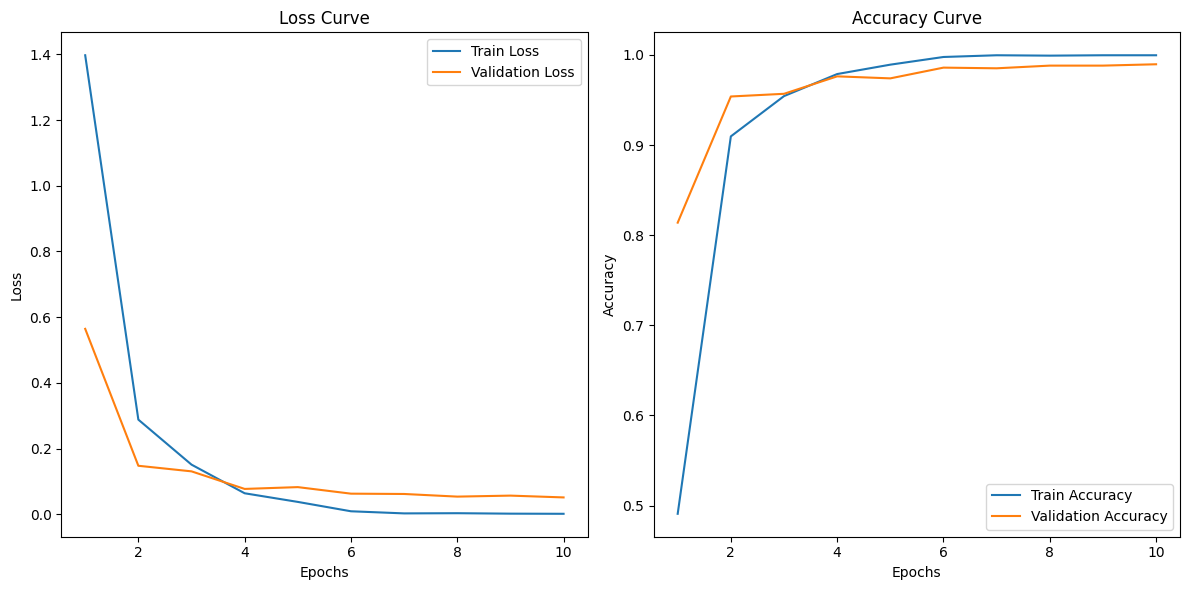

In [ ]:
# After training is complete, plot the learning curve
def plot_learning_curve(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = len(train_losses)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot function after training
plot_learning_curve(train_losses, val_losses, train_accuracies, val_accuracies)

The ConvNeXt model exhibits a well-behaved learning curve. Both training and validation loss decrease steadily over the 10 epochs, indicating effective learning without overfitting. The accuracy curves show a consistent increase for both training and validation sets, suggesting that the model is generalizing well to unseen data.

In [ ]:
# Save the final trained model
torch.save(model.state_dict(), 'ConvNeXt_model.pth')
print("Final trained model saved as 'ConvNeXt_model.pth'.")

Final trained model saved as 'ConvNeXt_model.pth'.


The final trained model, after completing the training process, has been saved as 'ConvNeXt_model.pth'. This model is now ready for inference and deployment. Saving the model allows us to persist the learned weights and parameters, making it possible to load and use the model for predictions without the need to retrain it each time.

## **Model Testing**

**Validation Function**

The `evaluate` function performs model evaluation on the validation dataset. It runs in inference mode (disabling dropout and batch normalization updates) to compute the loss and accuracy without altering model weights.

1. **Model Evaluation Mode**: Sets the model to evaluation mode using `model.eval()` to disable features like dropout.
2. **No Gradient Calculation**: `torch.no_grad()` ensures that gradients are not computed during validation, saving memory.
3. **Forward Pass**: For each batch in the validation dataset, the function makes predictions (`model(inputs)`) and calculates the loss.
4. **Accuracy Calculation**: It compares the predicted labels with the true labels and counts correct predictions.
5. **Metrics**: The function returns the average loss and accuracy across the entire validation dataset.

This function is used after each epoch to evaluate how well the model generalizes to unseen data.


In [ ]:
# Validation function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()

    accuracy = correct / len(dataloader.dataset)
    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy

In [ ]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.0294, Test Accuracy: 0.9911


In [ ]:
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [ ]:
from sklearn.metrics import classification_report

true_labels = np.array(all_labels)
predicted_labels = np.array(all_preds)

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=test_dataset.classes)
print(report)

                        precision    recall  f1-score   support

  Encapsulated_Lesions       1.00      1.00      1.00        66
          High_Density       0.97      1.00      0.99        67
   Infectious_Diseases       1.00      1.00      1.00        58
Inflammatory_Pneumonia       0.98      0.96      0.97       106
           Low_Density       0.97      1.00      0.98        63
   Mediastinal_Changes       1.00      1.00      1.00        60
                Normal       1.00      0.99      0.99       134
  Obstructive_Diseases       1.00      1.00      1.00        64
      Thoracic_Changes       1.00      1.00      1.00        54

              accuracy                           0.99       672
             macro avg       0.99      0.99      0.99       672
          weighted avg       0.99      0.99      0.99       672



The ConvNeXt model achieves 99% accuracy with excellent precision, recall, and F1-scores across all classes, demonstrating strong performance in classifying lung diseases.

<Figure size 1000x800 with 0 Axes>

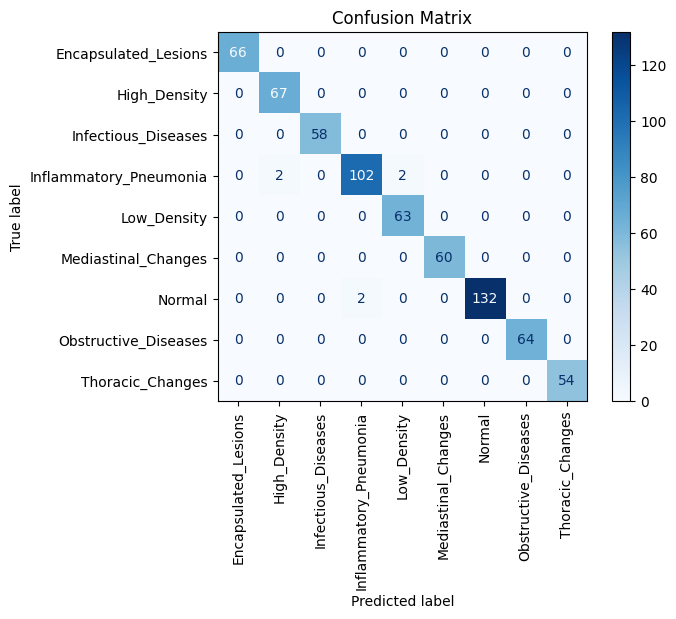

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.xticks(rotation=90)
plt.title("Confusion Matrix")
plt.show()


The confusion matrix shows that the ConvNeXt model performs well overall, with only a few misclassifications in the Inflammatory Pneumonia and Normal classes.

* We wanted to display an image from each class along with its true label and the predicted label for that image.



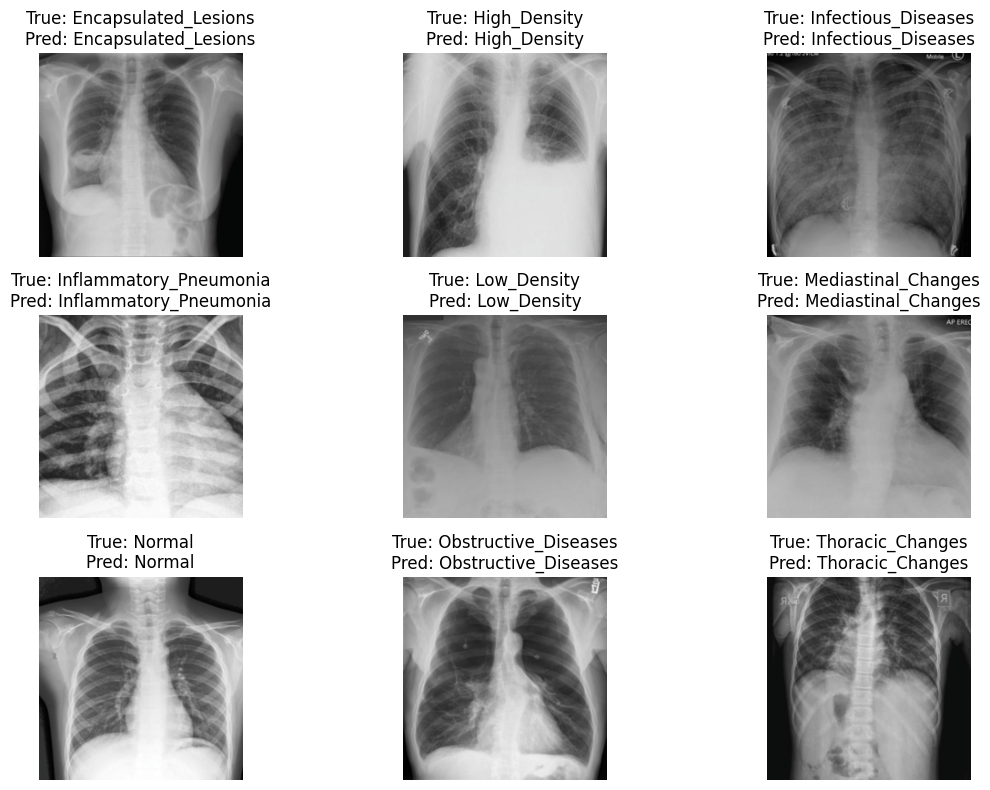

In [ ]:
# Class labels (adjust according to your dataset)
class_labels = train_dataset.classes  # e.g., ['Normal', 'Obstructive_Diseases', ...]

# Function to display image and label
def imshow(img, title):
    img = img.permute(1, 2, 0).cpu().numpy()  # Convert from Tensor to NumPy array
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Initialize placeholders for one image per class
images_per_class = {cls: None for cls in range(len(class_labels))}

# Find one correctly predicted image per class
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions = outputs.argmax(dim=1)

        for i in range(len(labels)):
            label = labels[i].item()
            pred = predictions[i].item()
            if label == pred and images_per_class[label] is None:
                images_per_class[label] = (inputs[i], label, pred)

        # Break loop if we have one image per class
        if all(images_per_class.values()):
            break

# Plot one image per class
plt.figure(figsize=(12, 8))
for i, cls in enumerate(images_per_class.keys()):
    if images_per_class[cls] is not None:
        img, true_label, pred_label = images_per_class[cls]
        plt.subplot(3, 3, i + 1)  # Adjust grid size (3, 3) for 9 classes
        imshow(img, title=f"True: {class_labels[true_label]}\nPred: {class_labels[pred_label]}")
plt.tight_layout()
plt.show()

* We wanted to display random images along with their true labels and predicted label values, randomly selected from any class, just to ensure the model is predicting correctly.

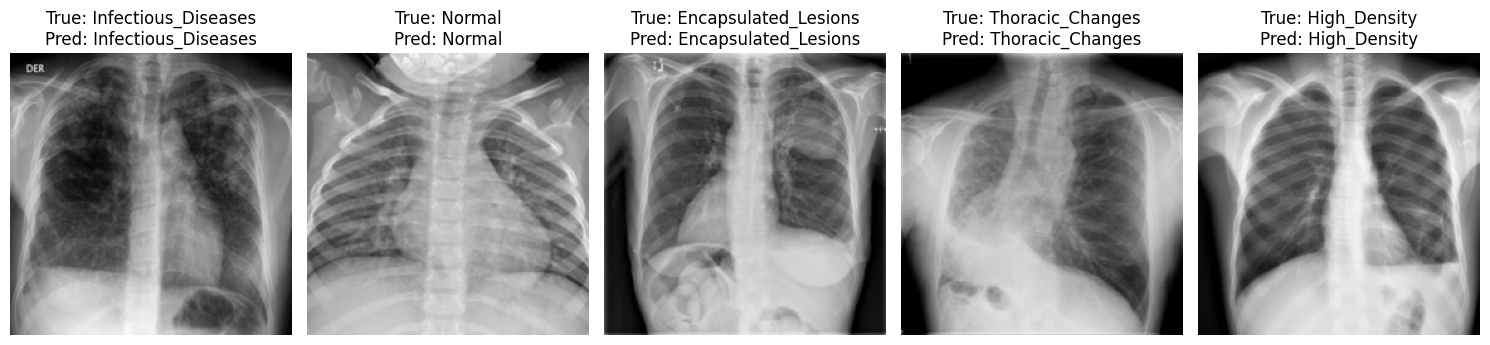

In [ ]:
# Function to display truly random images from the dataset
def display_random_images_from_dataset(model, dataset, class_labels, num_images=5):
    model.eval()
    random_indices = np.random.choice(len(dataset), size=num_images, replace=False)

    images, true_labels, predicted_labels = [], [], []

    # Loop through the random indices to fetch images
    with torch.no_grad():
        for idx in random_indices:
            img, label = dataset[idx]  # Get image and label from the dataset
            img_input = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
            output = model(img_input)
            pred_label = output.argmax(dim=1).item()

            images.append(img)  # Original unnormalized image
            true_labels.append(label)
            predicted_labels.append(pred_label)

    # Display the selected random images
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        img = images[i]
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)  # Unnormalize
        img = np.clip(img, 0, 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(to_pil_image(img))
        plt.title(f"True: {class_labels[true_labels[i]]}\nPred: {class_labels[predicted_labels[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
display_random_images_from_dataset(model, test_dataset, train_dataset.classes, num_images=5)

<center>

<font color='orange' font size =8>**Conclusion**



In [ ]:
model_comparison = {
    'Model': ['Xception', 'Basic CNN', 'ConvNeXt'],
    'Test Loss': [0.4069, 0.3792, 0.0294],
    'Test Accuracy': [0.8884, 0.8720, 0.9911]
}

df_comparison = pd.DataFrame(model_comparison)

df_comparison

Model  Test Loss  Test Accuracy
0   Xception     0.4069         0.8884
1  Basic CNN     0.3792         0.8720
2   ConvNeXt     0.0294         0.9911

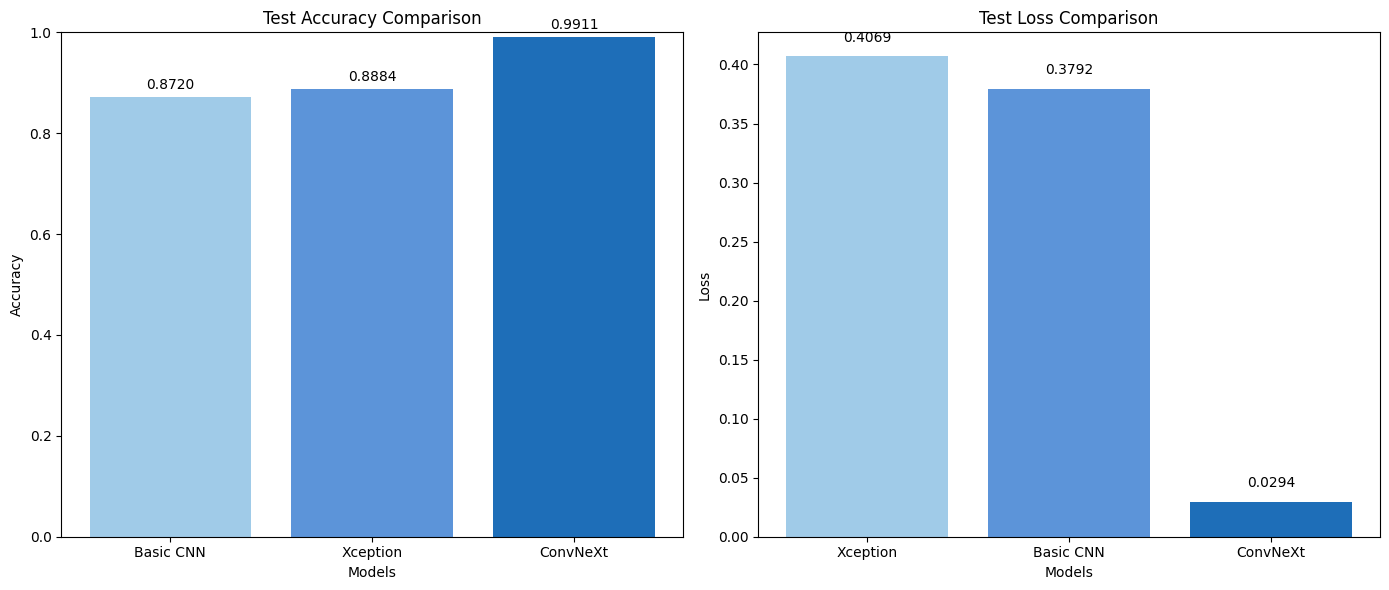

In [ ]:
# Sort the DataFrame by 'Test Accuracy' in ascending order and 'Test Loss' in descending order
df_comparison_sorted = df_comparison.sort_values(by='Test Accuracy', ascending=True)
df_comparison_sorted_loss = df_comparison.sort_values(by='Test Loss', ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot test accuracy
accuracy_colors = ['#A0CBE8', '#5C94D9', '#1E6EB8']
bars_accuracy = ax[0].bar(df_comparison_sorted['Model'], df_comparison_sorted['Test Accuracy'], color=accuracy_colors)
ax[0].set_title('Test Accuracy Comparison')
ax[0].set_xlabel('Models')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0, 1)  # Accuracy ranges from 0 to 1

# Add annotations for accuracy
for bar in bars_accuracy:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')

# Plot test loss
loss_colors = ['#A0CBE8', '#5C94D9', '#1E6EB8']
bars_loss = ax[1].bar(df_comparison_sorted_loss['Model'], df_comparison_sorted_loss['Test Loss'], color=loss_colors)
ax[1].set_title('Test Loss Comparison')
ax[1].set_xlabel('Models')
ax[1].set_ylabel('Loss')

# Add annotations for loss
for bar in bars_loss:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')

# Display the plots
plt.tight_layout()
plt.show()

In conclusion, we evaluated three models—Xception, a basic CNN, and ConvNeXt—on the lung disease classification task. The Xception model achieved a test accuracy of 88.84%, showing strong performance with robust feature extraction capabilities. The basic CNN model, while simpler, performed reasonably well with a test accuracy of 87.20%. However, the ConvNeXt model outperformed both, achieving a high accuracy of 99.11%, demonstrating its effectiveness in handling this task. The ConvNeXt model's superior performance, particularly in terms of precision and recall across all classes, makes it the most suitable model for this classification problem.







## Future Work Recommendations

---

* **Integration with Medical Systems:** Develop an end-to-end application integrating the best-performing model into healthcare systems for automated diagnostics.

* **Ensemble Methods:** Investigate combining multiple models, such as ConvNeXt and Xception, to leverage their strengths for better predictions.

* **Cross-Disease Analysis:** Expand the scope to detect and classify other related diseases using similar methodologies.

## References:

---

* https://www.kaggle.com/datasets/fernando2rad/x-ray-lung-diseases-images-9-classes
* https://keras.io/api/applications/xception/
* https://huggingface.co/docs/transformers/en/model_doc/convnext
* https://keras.io/api/layers/initializers/





### ConvNeXt model interface link:
https://huggingface.co/spaces/leenaalsalhi/ConvNeXt-Image-Classifier